In [19]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import statsmodels
import sklearn
import arch
import backtrader
import pyfolio
import xgboost

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import signal

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2


2024-08-02 18:48:15.013769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 18:48:15.033036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 18:48:15.038804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Today date is:  2024-08-02


In [4]:
'''
4. scikit-learn
Use Case: Machine learning and statistical modeling.
Features: Provides implementations of various machine learning algorithms and tools for model evaluation and selection.
5. Arch
Use Case: Financial econometrics.
Features: Focuses on ARCH (Autoregressive Conditional Heteroskedasticity) and GARCH (Generalized ARCH) models for volatility modeling.
6. matplotlib & seaborn
Use Case: Data visualization.
Features: These libraries help visualize time series data and statistical properties.
7. Quantlib
Use Case: Quantitative finance.
Features: Provides tools for pricing derivatives, calculating risk metrics, and other financial computations.
8. Backtrader
Use Case: Backtesting trading strategies.
Features: Allows for backtesting of trading strategies with a focus on time series data.
9. pyfolio
Use Case: Performance and risk analysis of financial portfolios.
Features: Provides functionalities for portfolio and risk analytics, including tear sheets
'''

In [322]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 60200
drwxrwxr-x 1 1000 1000    2360 Jul 17 10:00 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
-rw------- 1 1000 1000 1449984 Jun  4 00:49 20240601.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  3 23:44 20240602.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun  4 16:45 20240603.mktdata.ohlcv.db
-rw------- 1 1000 1000 1269760 Jun  5 10:00 20240604.mktdata.ohlcv.db
-rw------- 1 1000 1000 1081344 Jun  6 10:00 20240605.mktdata.ohlcv.db
-rw------- 1 1000 1000 1441792 Jun  7 10:00 20240606.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  8 10:00 20240607.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun  9 10:00 20240608.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jul  2 01:50 20240609.mktdata.ohlcv.db
-rw-r--r-- 1 1000 1000       0 Jul  2 16:45 20240609.mktdata.ohlcv_1min.db
-rw------- 1 1000 1000 1437696 Jun 11 10:00 20240610.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun 12 10:01 20240611.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun 

In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [3]:
directory = "/workspace/data/crypto_md"

# List of datesprint
dates = [
        '20240601', 
         '20240602', 
         '20240603',
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608',
         '20240609',
         '20240610' ,
         '20240611',
         '20240612',
         '20240613', 
         '20240614', 
         '20240615', 
         '20240616',  
         '20240617',
         '20240618',
         '20240619',
         '20240620',
         '20240621', 
         '20240622', 
         '20240623',
         '20240624',
         '20240625', 
         '20240626',
         '20240627',
         '20240628',
         '20240629',
         '20240630',
         '20240701',
         '20240702',
         '20240703',
         '20240704',
         '20240705',
         '20240706',
         '20240707'
         # '20240708',
         # '20240709',
         # '20240710',
         # '20240711',
         # '20240712',
         # '20240713',
         # '20240714',
         # '20240715'
        ]
   
# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    # Print the combined DataFrame
    # print(df_concat.shape[0])
    # print(df_concat.shape[1])
    conn.close()
print (df_concat.shape[0])
print (df_concat.head(3))
print (df_concat.tail(3))

210366
                tstamp exchange_id instrument_id      open      high  \
0  1717200000000000000    COINBASE  PAIR-BTC-USD  67473.07  67514.99   
1  1717200060000000000    COINBASE  PAIR-BTC-USD  67506.57  67515.00   
2  1717200120000000000    COINBASE  PAIR-BTC-USD  67494.73  67515.00   

        low     close    volume          vwap  
0  67468.13  67506.03  2.045049  67496.869352  
1  67480.66  67494.74  0.646759  67500.893305  
2  67455.91  67514.99  9.732906  67477.840770  
                     tstamp exchange_id instrument_id    open    high     low  \
210363  1720396620000000000    COINBASE  PAIR-XRP-USD  0.4200  0.4200  0.4195   
210364  1720396680000000000    COINBASE  PAIR-XRP-USD  0.4195  0.4196  0.4193   
210365  1720396740000000000    COINBASE  PAIR-XRP-USD  0.4194  0.4195  0.4192   

         close        volume      vwap  
210363  0.4195  70822.162247  0.419680  
210364  0.4193  36835.809457  0.419375  
210365  0.4195  41218.366701  0.419372  


In [4]:
df_concat['tstmp'] = pd.to_datetime(df_concat['tstamp'])

# Extract individual components
df_concat['year'] = df_concat['tstmp'].dt.year
df_concat['month'] = df_concat['tstmp'].dt.month
df_concat['day'] = df_concat['tstmp'].dt.day
df_concat['hour'] = df_concat['tstmp'].dt.hour
df_concat['minute'] = df_concat['tstmp'].dt.minute
df_concat['second'] = df_concat['tstmp'].dt.second

df_concat['date'] = df_concat['month'].astype(str) + '-' + df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['month', 'day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

print (df_concat.tail(3))

# instrument_list = df_concat['instrument_id'].unique().tolist()
# print("Distinct values in column 'instrument_id':", instrument_list)

             date instrument_id      close        volume         vwap
207486  7-7-23-59  PAIR-ETH-USD  2930.6100     16.442863  2929.596038
208925  7-7-23-59  PAIR-LTC-USD    62.0500    130.024857    61.982055
210365  7-7-23-59  PAIR-XRP-USD     0.4195  41218.366701     0.419372


In [5]:
# print (df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD'].tail(30))
# print (df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD'].tail(30))
# print (df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD'].tail(30))
# print (df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD'].tail(30))
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']
print (df_concat_btc.tail(3))

             date instrument_id     close     volume          vwap
206044  7-7-23-57  PAIR-BTC-USD  55881.99   9.262912  55898.793692
206045  7-7-23-58  PAIR-BTC-USD  55846.85  19.044228  55832.244248
206046  7-7-23-59  PAIR-BTC-USD  55854.09  11.059885  55849.715519


In [6]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_btc'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_btc'] = df_concat_btc['volume']
df_concat_btc['vwap_btc'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

# print (df_concat_btc.tail(30))

# LTC
df_concat_ltc = df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD']

# Reset Index
df_concat_ltc = df_concat_ltc.reset_index(drop = True)

# Rename Vars
df_concat_ltc['close_ltc'] = df_concat_ltc['close']/100.00
df_concat_ltc['volume_ltc'] = df_concat_ltc['volume']
df_concat_ltc['vwap_ltc'] = df_concat_ltc['vwap']/100.00

df_concat_ltc = df_concat_ltc.drop('close', axis = 1)
df_concat_ltc = df_concat_ltc.drop('volume', axis = 1)
df_concat_ltc = df_concat_ltc.drop('vwap', axis = 1)
df_concat_ltc = df_concat_ltc.drop('instrument_id', axis = 1)

# print (df_concat_ltc.head(3))

# ETH
df_concat_eth = df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD']

# Reset Index
df_concat_eth = df_concat_eth.reset_index(drop = True)

# Rename Vars
df_concat_eth['close_eth'] = df_concat_eth['close']/10000.00
df_concat_eth['volume_eth'] = df_concat_eth['volume']
df_concat_eth['vwap_eth'] = df_concat_eth['vwap']/10000.00

df_concat_eth = df_concat_eth.drop('close', axis = 1)
df_concat_eth = df_concat_eth.drop('volume', axis = 1)
df_concat_eth = df_concat_eth.drop('vwap', axis = 1)
df_concat_eth = df_concat_eth.drop('instrument_id', axis = 1)

print (df_concat_eth.tail(3))

# XRP
df_concat_xrp = df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD']

# Reset Index
df_concat_xrp = df_concat_xrp.reset_index(drop = True)

# Rename Vars
df_concat_xrp['close_xrp'] = df_concat_xrp['close']
df_concat_xrp['volume_xrp'] = df_concat_xrp['volume']
df_concat_xrp['vwap_xrp'] = df_concat_xrp['vwap']

df_concat_xrp = df_concat_xrp.drop('close', axis = 1)
df_concat_xrp = df_concat_xrp.drop('volume', axis = 1)
df_concat_xrp = df_concat_xrp.drop('vwap', axis = 1)
df_concat_xrp = df_concat_xrp.drop('instrument_id', axis = 1)

# print (df_concat_xrp.head(3))

df_M1 = pd.merge(df_concat_xrp, df_concat_eth, on = 'date', how = 'outer')
print (df_M1.tail(3))
print ("M1:  ", df_M1.shape[0])

#           date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
# 52615  7-7-9-7     0.4376   2599.821206  0.437600   0.301277   12.252974   
# 52616  7-7-9-8     0.4372  23718.539194  0.437213   0.301136    0.907615   
# 52617  7-7-9-9     0.4371   4330.750011  0.437266   0.301111    1.252245   

# 'month', 'day', 'hour', 'minute'
# Oleg, is it possible that a data for XRP were sptopped to be collected at July 7.
# Please, check.

df_M2 = pd.merge(df_M1, df_concat_ltc, on = 'date', how = 'outer')
# print (df_M2.head(3))
# print ("M2:  ", df_M2.shape[0])
df_M3 = pd.merge(df_M2, df_concat_btc, on = 'date', how = 'outer')
# print (df_M3.head(3))
# print ("M3:  ", df_M3.shape[0])

# Drop rows with any NaN value and assign it to a new DataFrame
sample = df_M3.dropna(axis = 0).reset_index(drop = True)

print ("========================================")
print (sample.head(2))
print (sample.tail(2))
sample_size = sample.shape[0]
print ("test sample size: ", sample_size)

            date  close_eth  volume_eth  vwap_eth
52614  7-7-23-57   0.292887   36.680197  0.292978
52615  7-7-23-58   0.292983  102.079982  0.292911
52616  7-7-23-59   0.293061   16.442863  0.292960
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
52615  7-7-9-7     0.4376   2599.821206  0.437600   0.301277   12.252974   
52616  7-7-9-8     0.4372  23718.539194  0.437213   0.301136    0.907615   
52617  7-7-9-9     0.4371   4330.750011  0.437266   0.301111    1.252245   

       vwap_eth  
52615  0.301410  
52616  0.301256  
52617  0.301146  
M1:   52618
      date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
0  6-1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964   
1  6-1-0-1     0.5170  10184.511212  0.517060   0.375942   11.703305   

   vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  
0  0.376108     0.8317  110.056253  0.831662   0.675060    2.045049  0.674969  
1  0.376013     0.8312  176.868598

In [7]:
print ('df_M1 shape:  ', df_M1.shape[0])
print ('df_M2 shape:  ', df_M2.shape[0])
print ('df_M3 shape:  ', df_M3.shape[0])

print ('sample shape: ', sample.shape[0])

df_M1 shape:   52618
df_M2 shape:   52618
df_M3 shape:   52618
sample shape:  52516


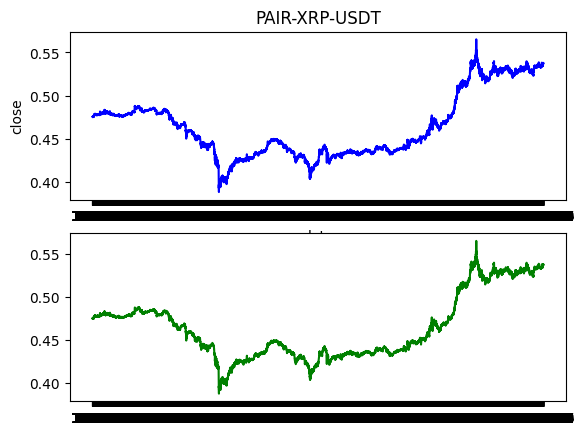

In [175]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_xrp['date'], df_concat_xrp['close_xrp'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-XRP-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_xrp['date'], df_concat_xrp['vwap_xrp'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

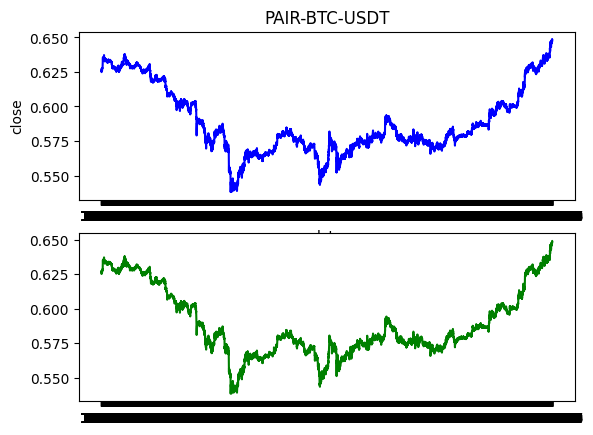

In [176]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_btc'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

In [8]:
split_index = round(sample.shape[0] * 0.8)

# First part of the DataFrame
sample_test = sample.iloc[:split_index]

# Second part of the DataFrame
sample_valid = sample.iloc[split_index:]

print("\nFirst part of the DataFrame:")
print (sample_test.tail(2))

print("\nSecond part of the DataFrame:")
print (sample_valid.head(2))


First part of the DataFrame:
            date  close_xrp   volume_xrp  vwap_xrp  close_eth  volume_eth  \
42011  6-9-22-15     0.4989  4219.151010  0.498820   0.371410   19.179327   
42012  6-9-22-16     0.4991  7127.748279  0.499099   0.371796   41.245680   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
42011  0.371428     0.8051   24.749003  0.805129   0.696990    0.909656   
42012  0.371544     0.8054   46.512380  0.804995   0.697354    1.479938   

       vwap_btc  
42011  0.696948  
42012  0.697224  

Second part of the DataFrame:
            date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
42013  6-9-22-17     0.4991   6028.655908  0.499069   0.371699   24.639615   
42014  6-9-22-18     0.4991  27772.155557  0.499006   0.371520   15.982663   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
42013  0.371743     0.8053  127.209143  0.805103   0.697080    3.752468   
42014  0.371601     0.8052   39.219555  0.

In [9]:
# Detrend Series Function
# =========================
def detrend_series(series):
    trend = np.polyfit(np.arange(len(series)), series.values, 1)
    trend_line = np.polyval(trend, np.arange(len(series)))
    detrended_series = series - trend_line
    return detrended_series

crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']

In [94]:
#  Model Input
# =============================================
sl = 132 # <--- sequence length
batch = 100  # <--- batch size
n_features = 4 # <---- no. of variables
n_out = 4 # <----- no. of predicted variables
frwd = 10 # <----- how many to predict
# =============================================

print ('sample_size')
print (sample_size)
print ('===========================================================')

# Trimming Indices !!!
# Marking selected rows
# sample_test['Selected'] = 0
sample_test.loc[:, 'Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 

# print ('Selected Indices')
# print (selected_indices)

chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
print ('Selected Indices: chosen_idx1')
print (chosen_idx1)
print (type(chosen_idx1))

# =============================================
# thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
# cnt_thrown_idx1 = len(thrown_idx1)

# chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

# thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
# cnt_thrown_idx2 = len(thrown_idx2)
# =============================================

cnt_thrown_idx1 = 0
cnt_thrown_idx2 = 0

for idx in chosen_idx1:
    # print (sample_test.iloc[idx-(sl-1): idx+(frwd+1)])
    # print (idx-(sl-1), idx+(frwd+1))
    
    if (idx-(sl-1) < 0):
       print ('scratch index on a left:  ', idx)
       cnt_thrown_idx1 = cnt_thrown_idx1 + 1
       print ('cnt_thrown_idx1:  ', cnt_thrown_idx1)
       chosen_idx1 = chosen_idx1.drop(idx)
       print (chosen_idx1)
        
print (' ============ Second Cycle ========================= ')

for idx in chosen_idx1:
    if (idx+(frwd+1) > sample_size):
       print ('scratch index on a right:  ', idx)
       cnt_thrown_idx2 = cnt_thrown_idx2 + 1
       print ('cnt_thrown_idx2:  ', cnt_thrown_idx2)
       chosen_idx1 = chosen_idx1.drop(idx)
       print (chosen_idx1)


print ('cnt_thrown_idx1:  ', cnt_thrown_idx1)
print ('cnt_thrown_idx2:  ', cnt_thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2
print ('cnt_thrown_idx:  ', cnt_thrown_idx)

print ('batch: ', batch)



sample_size
52516
Selected Indices: chosen_idx1
Index([ 1016,  1131,  1953,  2129,  2796,  3662,  3919,  3941,  4310,  5055,
        5397,  5574,  5675,  5932,  6285,  6382,  7087,  7360,  8970,  9178,
        9330,  9962, 10763, 10809, 10817, 10824, 11099, 11167, 11300, 11762,
       12173, 12223, 13106, 13364, 13902, 13943, 14958, 16450, 16547, 18574,
       18630, 18779, 19163, 19201, 19784, 20026, 20056, 20341, 20553, 21353,
       21446, 22483, 22585, 22593, 23067, 23514, 23735, 23979, 24696, 25290,
       25527, 26205, 27140, 27318, 27581, 27652, 27784, 27790, 28764, 30219,
       30562, 30884, 31448, 32508, 32808, 32842, 32922, 34466, 34946, 35256,
       35551, 36201, 36422, 36588, 36765, 36970, 37071, 37446, 37596, 37771,
       38028, 39006, 39095, 39668, 39934, 40092, 40706, 41006, 41633, 41636],
      dtype='int64')
<class 'pandas.core.indexes.base.Index'>
 ============ Second Cycle ========================= 
cnt_thrown_idx1:   0
cnt_thrown_idx2:   0
cnt_thrown_idx:   0
bat

In [98]:
#  Model Input
# =============================================
sl = 132 # <--- sequence length
batch = 100  # <--- batch size
n_features = 4 # <---- no. of variables
n_out = 4 # <----- no. of predicted variables
frwd = 10 # <----- how many to predict
# =============================================

print ('sample_size')
print (sample_size)
# print ('===========================================================')

# Trimming Indices !!!
# Marking selected rows
# sample_test['Selected'] = 0
sample_test.loc[:, 'Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 

chosen_idx = sample_test[sample_test['Selected'] == 1].index

cnt_thrown_idx1 = 0
cnt_thrown_idx2 = 0

for idx in chosen_idx:    
    if (idx-(sl-1) < 0):
       # print ('scratch index on a left:  ', idx)
       cnt_thrown_idx1 = cnt_thrown_idx1 + 1
       # print ('cnt_thrown_idx1:  ', cnt_thrown_idx1)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

for idx in chosen_idx:
    if (idx+(frwd+1) > sample_size):
       # print ('scratch index on a right:  ', idx)
       cnt_thrown_idx2 = cnt_thrown_idx2 + 1
       # print ('cnt_thrown_idx2:  ', cnt_thrown_idx2)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]
  # print ('idx:  ', idx)

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  

# Compute the weighted average
  weighted_avg_xrp = np.average(sr_after_close_xrp, weights = sr_after_volume_xrp)
  # print ('XRP w.average:  ', weighted_avg_xrp)

# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])

# Compute the weighted average
  weighted_avg_eth = np.average(sr_after_close_eth, weights = sr_after_volume_eth)
  # print ('ETH w.average:  ', weighted_avg_eth)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])

# Compute the weighted average
  weighted_avg_ltc = np.average(sr_after_close_ltc, weights = sr_after_volume_ltc)
  # print ('LTC w.average:  ', weighted_avg_ltc)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])

# Compute the weighted average
  weighted_avg_btc = np.average(sr_after_close_btc, weights = sr_after_volume_btc)
  # print ('BTC w.average:  ', weighted_avg_btc)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))

  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))

X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]

X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]

# X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
#                       X_ETH_close, X_ETH_volume, 
#                       X_LTC_close, X_LTC_volume, 
#                       X_BTC_close, X_BTC_volume))

X0 = np.column_stack((X_XRP_close,
                      X_ETH_close,
                      X_LTC_close,
                      X_BTC_close))
# print (X0)

# ================ Model Input ===========================
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
# print ('================ original series =================')    
# print ('XXXX ====== Actual Input ====== XXXX')
# print (X)
# print (X.shape)

# print ('================== trend lines ===================')   

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]
# print ('y_BTC:  ', y_BTC)

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y)

y = y.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
# print (y)
# print (y.shape)

X_trend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print ('X_trend')
# print (X_trend)

X_detrend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print ('X_detrend')
# print (X_detrend)

y_trend = np.zeros((batch-cnt_thrown_idx, frwd, n_out))
# print ('y_trend')
# print (y_trend)

for j in range(batch-cnt_thrown_idx):
    df_trend = pd.DataFrame(X[j], columns = crypto_list)
    # print (df_trend)
 
# XRP
    coef_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
    # print ("coef_xrp:  ", coef_xrp) 
    trend_line_xrp = np.polyval(coef_xrp, np.arange(len(df_trend)))
    detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
    detrend_xrp = detrended_series_xrp.to_numpy()  

    y_xrp_trend = np.empty(frwd)
    # print ('y_xrp_trend:  ', y_xrp_trend)
    for f in range(frwd):
        y_xrp_trend[f] = coef_xrp[0]*(len(df_trend)+f) + coef_xrp[1] 
        # print (y_xrp_trend[f])

    # ETH
    coef_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
    # print ("coef_eth:  ", coef_eth)
    trend_line_eth = np.polyval(coef_eth, np.arange(len(df_trend)))
    detrended_series_eth = df_trend['ETH'] - trend_line_eth
    detrend_eth = detrended_series_eth.to_numpy()

    y_eth_trend = np.empty(frwd)
    # print ('y_eth_trend:  ', y_eth_trend)
    for f in range(frwd):
        y_eth_trend[f] = coef_eth[0]*(len(df_trend)+f) + coef_eth[1] 
        # print (y_eth_trend[f])
  
# LTC    
    coef_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
    # print ("coef_ltc:  ", coef_ltc)
    trend_line_ltc = np.polyval(coef_ltc, np.arange(len(df_trend)))
    detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
    detrend_ltc = detrended_series_ltc.to_numpy()

    y_ltc_trend = np.empty(frwd)
    # print ('y_ltc_trend:  ', y_ltc_trend)
    for f in range(frwd):
        y_ltc_trend[f] = coef_ltc[0]*(len(df_trend) + f) + coef_ltc[1] 
        # print (y_ltc_trend[f])

# BTC    
    coef_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
    # print ("coef_btc:  ", coef_btc)
    trend_line_btc = np.polyval(coef_btc, np.arange(len(df_trend)))
    detrended_series_btc = df_trend['BTC'] - trend_line_btc
    detrend_btc = detrended_series_btc.to_numpy()

    y_btc_trend = np.empty(frwd)
    # print ('y_btc_trend:  ', y_btc_trend)
    for f in range(frwd):
        y_btc_trend[f] = coef_btc[0]*(len(df_trend) + f) + coef_btc[1] 
        # print (y_btc_trend[f])

    # print ('y_btc_trend:  ', y_btc_trend)
    # print ('type of y_btc_trend:  ', type (y_btc_trend))
        
    # Create a dictionary with the data
    trend_dict = {'XRP' : trend_line_xrp, 
                  'ETH' : trend_line_eth, 
                  'LTC' : trend_line_ltc, 
                  'BTC' : trend_line_btc
                 }
    df = pd.DataFrame(trend_dict)
    
    # Fill the DataFrame column by column
    for col, values in trend_dict.items():
        df[col] = values
    
    X0_trend = df.to_numpy()
 
    X_trend[j] += X0_trend 

    detrend_dict = {'XRP' : detrend_xrp, 
                    'ETH' : detrend_eth, 
                    'LTC' : detrend_ltc, 
                    'BTC' : detrend_btc
                   }
    
    df = pd.DataFrame(detrend_dict)

    # Fill the DataFrame column by column
    for col, values in detrend_dict.items():
        df[col] = values

    X0_detrend = df.to_numpy()

    X_detrend[j] += X0_detrend 
    
    # Create a dictionary with the data
    # y_trend_dict = {'XRP' : np.array([y_xrp_trend]), 
    #                 'ETH' : np.array([y_eth_trend]), 
    #                 'LTC' : np.array([y_ltc_trend]), 
    #                 'BTC' : np.array([y_btc_trend])
    #                }

    # Create a dictionary with the data
    y_trend_dict = {'XRP' : y_xrp_trend, 
                    'ETH' : y_eth_trend, 
                    'LTC' : y_ltc_trend, 
                    'BTC' : y_btc_trend
                   }
    # print (y_trend_dict)

    df1 = pd.DataFrame(y_trend_dict)

    
    # Fill the DataFrame column by column
    for key, value in y_trend_dict.items():
        # print(f"{key}: {value}")
        df1[key] = value

    y_tr = df1.to_numpy()
    y_trend[j] += y_tr
    
y_detrend = y - y_trend
# print ('YYYY ====== Actual Input ====== YYYY')
# print (y)
# print (y.shape)

# print ('YYYY ====== Trend Input ======= YYYY')
# print (y_trend)
# print (type(y_trend))
# print (y_trend.shape)

# print ('YYYY ====== De-Trend Input ======= YYYY')
# print (y_detrend)
# print (type(y_detrend))
# print (y_detrend.shape)

sample_size
52516


In [ ]:
''' Keep this for reference 07.20.2024 '''

In [374]:
# De-Trend Model
# variables are close and volume
# ==============================
#  Test Sample --- 06.20.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)
print ('=============================================')
# Model Input
# =============================================
sl = 8 # <--- sequence length
batch = 1  # <--- batch size
n_features = 4 # <---- no. of variables
n_out = 4 # <----- no. of predicted variables
frwd =  5 # <--- how many to predict
# =============================================

# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)
print ('=============================================')


all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output

aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
# Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
# Compute the weighted average
  weighted_avg_xrp = np.average(sr_after_close_xrp, weights = sr_after_volume_xrp)
  # print ('XRP w.average:  ', weighted_avg_xrp)

# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
# Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
# Compute the weighted average
  weighted_avg_eth = np.average(sr_after_close_eth, weights = sr_after_volume_eth)
  # print ('ETH w.average:  ', weighted_avg_eth)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
# Compute the weighted average
  weighted_avg_ltc = np.average(sr_after_close_ltc, weights = sr_after_volume_ltc)
  # print ('LTC w.average:  ', weighted_avg_ltc)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
# Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
# Compute the weighted average
  weighted_avg_btc = np.average(sr_after_close_btc, weights = sr_after_volume_btc)
  # print ('BTC w.average:  ', weighted_avg_btc)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))

  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))

X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

# X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
#                       X_ETH_close, X_ETH_volume, 
#                       X_LTC_close, X_LTC_volume, 
#                       X_BTC_close, X_BTC_volume))

X0 = np.column_stack((X_XRP_close,
                      X_ETH_close,
                      X_LTC_close,
                      X_BTC_close))
# print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
# print ('================ original series =================')    
# print ('XXXX ====== Actual Input ====== XXXX')
# print (X)
# print (X.shape)

# print ('================== trend lines ===================')   


y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y)

y = y.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)


def detrend_series(series):
    trend = np.polyfit(np.arange(len(series)), series.values, 1)
    trend_line = np.polyval(trend, np.arange(len(series)))
    detrended_series = series - trend_line
    return detrended_series


crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']
X_trend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print (X_trend)
X_detrend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print (X_detrend)
y_trend = np.zeros((batch-cnt_thrown_idx, frwd, n_out))
# print (y_trend)

for j in range(batch-cnt_thrown_idx):
    df_trend = pd.DataFrame(X[j], columns = crypto_list)
    # print (df_trend)
    # print (j)
# XRP
    coef_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
    # print ("coef_xrp:  ", coef_xrp)     #  coef_xrp:   [-0.00074848  0.48839818]
    trend_line_xrp = np.polyval(coef_xrp, np.arange(len(df_trend)))
    detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
    detrend_xrp = detrended_series_xrp.to_numpy()  

    y_xrp_trend = coef_xrp[0]*(len(df_trend)) + coef_xrp[1]
    
# ETH
    coef_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
    # print ("coef_eth:  ", coef_eth)
    trend_line_eth = np.polyval(coef_eth, np.arange(len(df_trend)))
    detrended_series_eth = df_trend['ETH'] - trend_line_eth
    detrend_eth = detrended_series_eth.to_numpy()

    y_eth_trend = coef_eth[0]*(len(df_trend)) + coef_eth[1]
    
# LTC    
    coef_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
    # print ("coef_ltc:  ", coef_ltc)
    trend_line_ltc = np.polyval(coef_ltc, np.arange(len(df_trend)))
    detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
    detrend_ltc = detrended_series_ltc.to_numpy()
    
    y_ltc_trend = coef_ltc[0]*(len(df_trend)) + coef_ltc[1]

# BTC    
    coef_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
    # print ("coef_btc:  ", coef_btc)
    trend_line_btc = np.polyval(coef_btc, np.arange(len(df_trend)))
    detrended_series_btc = df_trend['BTC'] - trend_line_btc
    detrend_btc = detrended_series_btc.to_numpy()

    y_btc_trend = coef_btc[0]*(len(df_trend)) + coef_btc[1]

    # print (X[j])
    # print (type(X[j]))
    # print (X[j].shape)
    # print ('==================================================')
        
    # Create a dictionary with the data
    trend_dict = {'XRP' : trend_line_xrp, 
                  'ETH' : trend_line_eth, 
                  'LTC' : trend_line_ltc, 
                  'BTC' : trend_line_btc
                 }
    df = pd.DataFrame(trend_dict)
    
    # Fill the DataFrame column by column
    for col, values in trend_dict.items():
        df[col] = values
    
    X0_trend = df.to_numpy()
    # print (X0_trend)
    # print (type(X0_trend))
    # print (X0_trend.shape)

    X_trend[j] += X0_trend 

    detrend_dict = {'XRP' : detrend_xrp, 
                    'ETH' : detrend_eth, 
                    'LTC' : detrend_ltc, 
                    'BTC' : detrend_btc
                   }
    # print ('detrend_dict')
    # print (detrend_dict)
    
    df = pd.DataFrame(detrend_dict)

    # Fill the DataFrame column by column
    for col, values in detrend_dict.items():
        df[col] = values

    X0_detrend = df.to_numpy()
    # print (X0_detrend)
    # print (type(X0_detrend))
    # print (X0_detrend.shape)

    X_detrend[j] += X0_detrend 
    
    # print ('================ originalseries ==================')    
    # print (X)
    # print (type(X))
    # print (X_trend.shape)
    
    # print ('================== trend lines ===================')    
    # print (X_trend)
    # print (type(X_trend))
    # print (X_trend.shape)
    
    # print ('================== fluctuations ===================')    
    # print (X_detrend)
    # print (type(X_detrend))
    # print (X_detrend.shape)

    # print ('y_xrp_trend:  ', y_xrp_trend)
    # print ('y_eth_trend:  ', y_eth_trend)
    # print ('y_ltc_trend:  ', y_ltc_trend)
    # print ('y_btc_trend:  ', y_btc_trend)

    # print (type(y_xpr_trend))
    # print (y_xpr_trend.shape)

    # Create a dictionary with the data
    y_trend_dict = {'XRP' : np.array([y_xrp_trend]), 
                    'ETH' : np.array([y_eth_trend]), 
                    'LTC' : np.array([y_ltc_trend]), 
                    'BTC' : np.array([y_btc_trend])
                   }
    # print (y_trend_dict)

    df1 = pd.DataFrame(y_trend_dict)
   
    # Fill the DataFrame column by column
    for key, value in y_trend_dict.items():
        # print(f"{key}: {value}")
        df1[key] = value

    y_tr = df1.to_numpy()
    y_trend[j] += y_tr

print ('================ original series =================')    
# print (X)
print (type(X))
print (X_trend.shape)

print ('================== trend lines ===================')    
# print (X_trend)
print (type(X_trend))
print (X_trend.shape)

print ('================== fluctuations ===================')    
# print (X_detrend)
print (type(X_detrend))
print (X_detrend.shape)

print ('YYYY ====== Actual Input ====== YYYY')
# print (y)
print (y.shape)

print ('YYYY ====== Trend Input ======= YYYY')
# print (y_trend)
print (type(y_trend))
print (y_trend.shape)

print ('YYYY ====== De-Trend Input ======= YYYY')
y_detrend = y - y_trend
# print (y_detrend)
print (type(y_detrend))
print (y_detrend.shape)

sample_size:  42013
[22585]
(1, 5, 4)
================ original series =================
<class 'numpy.ndarray'>
(1, 8, 4)
================== trend lines ===================
<class 'numpy.ndarray'>
(1, 8, 4)
================== fluctuations ===================
<class 'numpy.ndarray'>
(1, 8, 4)
YYYY ====== Actual Input ====== YYYY
(1, 5, 4)
YYYY ====== Trend Input ======= YYYY
<class 'numpy.ndarray'>
(1, 5, 4)
YYYY ====== De-Trend Input ======= YYYY
<class 'numpy.ndarray'>
(1, 5, 4)


/tmp/ipykernel_12052/1935672674.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_test['Selected'] = 0


In [ ]:
''' Also for reference '''

In [417]:
# Do not run !!! Detrending help!
# 07.09.2024
# need function to create trend and de-trend
crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']
X_trend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print (X_trend)
X_detrend = np.zeros((batch-cnt_thrown_idx, sl, n_features))
# print (X_detrend)
y_trend = np.zeros((batch-cnt_thrown_idx, frwd, n_out))
# print (y_trend)
for j in range(batch-cnt_thrown_idx):
    df_trend = pd.DataFrame(X[j], columns = crypto_list)
    # print (df_trend)
    # print (j)
# XRP
    coef_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
    # print ("coef_xrp:  ", coef_xrp)     #  coef_xrp:   [-0.00074848  0.48839818]
    trend_line_xrp = np.polyval(coef_xrp, np.arange(len(df_trend)))
    detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
    detrend_xrp = detrended_series_xrp.to_numpy()  

    y_xrp_trend = coef_xrp[0]*(len(df_trend)) + coef_xrp[1]
    
# ETH
    coef_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
    # print ("coef_eth:  ", coef_eth)
    trend_line_eth = np.polyval(coef_eth, np.arange(len(df_trend)))
    detrended_series_eth = df_trend['ETH'] - trend_line_eth
    detrend_eth = detrended_series_eth.to_numpy()

    y_eth_trend = coef_eth[0]*(len(df_trend)) + coef_eth[1]
    
# LTC    
    coef_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
    # print ("coef_ltc:  ", coef_ltc)
    trend_line_ltc = np.polyval(coef_ltc, np.arange(len(df_trend)))
    detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
    detrend_ltc = detrended_series_ltc.to_numpy()
    
    y_ltc_trend = coef_ltc[0]*(len(df_trend)) + coef_ltc[1]

# BTC    
    coef_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
    # print ("coef_btc:  ", coef_btc)
    trend_line_btc = np.polyval(coef_btc, np.arange(len(df_trend)))
    detrended_series_btc = df_trend['BTC'] - trend_line_btc
    detrend_btc = detrended_series_btc.to_numpy()

    y_btc_trend = coef_btc[0]*(len(df_trend)) + coef_btc[1]


    # print (X[j])
    # print (type(X[j]))
    # print (X[j].shape)
    print ('==================================================')
        
    # Create a dictionary with the data
    trend_dict = {'XRP' : trend_line_xrp, 
                  'ETH' : trend_line_eth, 
                  'LTC' : trend_line_ltc, 
                  'BTC' : trend_line_btc
                 }
    df = pd.DataFrame(trend_dict)
    
    # Fill the DataFrame column by column
    for col, values in trend_dict.items():
        df[col] = values
    
    X0_trend = df.to_numpy()
    # print (X0_trend)
    # print (type(X0_trend))
    # print (X0_trend.shape)

    X_trend[j] += X0_trend 

    detrend_dict = {'XRP' : detrend_xrp, 
                    'ETH' : detrend_eth, 
                    'LTC' : detrend_ltc, 
                    'BTC' : detrend_btc
                   }
    # print ('detrend_dict')
    # print (detrend_dict)
    
    df = pd.DataFrame(detrend_dict)

    # Fill the DataFrame column by column
    for col, values in detrend_dict.items():
        df[col] = values

    X0_detrend = df.to_numpy()
    # print (X0_detrend)
    # print (type(X0_detrend))
    # print (X0_detrend.shape)

    X_detrend[j] += X0_detrend 
    
    print ('================ originalseries ==================')    
    print (X)
    print (type(X))
    print (X_trend.shape)
    
    print ('================== trend lines ===================')    
    print (X_trend)
    print (type(X_trend))
    print (X_trend.shape)
    
    print ('================== fluctuations ===================')    
    print (X_detrend)
    print (type(X_detrend))
    print (X_detrend.shape)

    # print ('y_xrp_trend:  ', y_xrp_trend)
    # print ('y_eth_trend:  ', y_eth_trend)
    # print ('y_ltc_trend:  ', y_ltc_trend)
    # print ('y_btc_trend:  ', y_btc_trend)

    # print (type(y_xpr_trend))
    # print (y_xpr_trend.shape)


    # Create a dictionary with the data
    y_trend_dict = {'XRP' : np.array([y_xrp_trend]), 
                    'ETH' : np.array([y_eth_trend]), 
                    'LTC' : np.array([y_ltc_trend]), 
                    'BTC' : np.array([y_btc_trend])
                   }
    # print (y_trend_dict)

    df1 = pd.DataFrame(y_trend_dict)

    # print ('df1')
    # print (df1)
    # print (type(df1))
    # print (df1.shape)
    
    # Fill the DataFrame column by column
    for key, value in y_trend_dict.items():
        # print(f"{key}: {value}")
        df1[key] = value

    y_tr = df1.to_numpy()
    # print (y_tr)
    # print (type(y_tr))
    # print (y_tr.shape)

    y_trend[j] += y_tr
    # print (y_trend[j])

print ('YYYY ====== Actual Input ====== YYYY')
print (y)
print (y.shape)

print ('YYYY ====== Trend Input ======= YYYY')
print (y_trend)
print (y_trend.shape)

print ('YYYY ====== De-Trend Input ======= YYYY')
y_detrend = y - y_trend
print (y_detrend)
print (y_detrend.shape)

================ originalseries ==================
[[[0.4868    0.350832  0.779     0.677174 ]
  [0.4866    0.351193  0.7795    0.6772912]
  [0.4876    0.353344  0.7803    0.6792004]
  [0.4872    0.353177  0.7798    0.6791705]
  [0.4875    0.353262  0.78      0.6792673]
  [0.4871    0.353043  0.7797    0.6791533]
  [0.4819    0.348065  0.7933    0.6661308]
  [0.4822    0.348321  0.7935    0.6665988]
  [0.4817    0.347804  0.7919    0.6659405]
  [0.4817    0.347927  0.7929    0.666058 ]]

 [[0.4912    0.355146  0.7961    0.6608529]
  [0.4909    0.356019  0.7988    0.6610751]
  [0.4914    0.355301  0.7965    0.6610207]
  [0.4911    0.355165  0.7963    0.6609463]
  [0.4905    0.355011  0.7967    0.6608   ]
  [0.4901    0.355105  0.7968    0.6608531]
  [0.49      0.35507   0.7965    0.6608001]
  [0.4898    0.354964  0.7963    0.6607066]
  [0.4908    0.355174  0.7968    0.6609373]
  [0.4904    0.355062  0.7969    0.6608471]]

 [[0.4922    0.351055  0.7344    0.6464964]
  [0.4919    0.351305

In [ ]:
'''
    06.26.2014           Trends and Seasonalities
========================================================
'''

In [97]:
print (X[1])
print (type(X[1]))
print (X[1].shape)

[[0.518     0.381374  0.8328    0.6768447]
 [0.5178    0.381286  0.833     0.676803 ]
 [0.5179    0.381262  0.8334    0.6767874]
 [0.5181    0.381318  0.8336    0.6769821]
 [0.5181    0.381319  0.8336    0.6769545]
 [0.5194    0.381879  0.8339    0.6775872]
 [0.5181    0.381309  0.8335    0.6769801]
 [0.5182    0.381268  0.8339    0.6770658]
 [0.5182    0.381239  0.834     0.6770058]
 [0.518     0.381319  0.8345    0.6770314]
 [0.5183    0.381321  0.8346    0.6770791]
 [0.518     0.38122   0.8344    0.6770408]
 [0.518     0.38129   0.8343    0.6771225]
 [0.5181    0.381263  0.8343    0.6771321]
 [0.5182    0.381285  0.8343    0.6772544]
 [0.5184    0.381248  0.8343    0.6771928]
 [0.5192    0.381742  0.8338    0.6775069]
 [0.5194    0.381742  0.8337    0.6775913]
 [0.5191    0.381445  0.8336    0.6774632]
 [0.5194    0.381585  0.8336    0.6774229]
 [0.5186    0.377405  0.8317    0.6764568]
 [0.5188    0.377499  0.8317    0.6764784]
 [0.5189    0.37761   0.8317    0.6764024]
 [0.5188   

In [465]:
crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']

df_trend = pd.DataFrame(X[0], columns = crypto_list)

# XRP
trend_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
print ("coef:  ", trend_xrp)
trend_line_xrp = np.polyval(trend_xrp, np.arange(len(df_trend)))
print (trend_line_xrp)
detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
print (detrended_series_xrp)
detrend_xrp = detrended_series_xrp.to_numpy()
print (detrend_xrp)

# ETH
trend_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
print ("coef:  ", trend_eth)
trend_line_eth = np.polyval(trend_eth, np.arange(len(df_trend)))
detrended_series_eth = df_trend['ETH'] - trend_line_eth
detrend_eth = detrended_series_eth.to_numpy()


trend_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
print ("coef:  ", trend_ltc)
trend_line_ltc = np.polyval(trend_ltc, np.arange(len(df_trend)))
detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
detrend_ltc = detrended_series_ltc.to_numpy()


trend_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
print ("coef:  ", trend_btc)
trend_line_btc = np.polyval(trend_btc, np.arange(len(df_trend)))
detrend_btc = detrended_series_btc.to_numpy()


coef:   [-0.006   0.5293]
[0.5293 0.5233 0.5173 0.5113 0.5053 0.4993 0.4933 0.4873]
0   -0.0105
1   -0.0045
2    0.0015
3    0.0075
4    0.0135
5    0.0195
6   -0.0165
7   -0.0105
Name: XRP, dtype: float64
[-0.0105 -0.0045  0.0015  0.0075  0.0135  0.0195 -0.0165 -0.0105]
coef:   [-9.38309713e-18  3.62264000e-01]
coef:   [0.00694286 0.76905   ]
coef:   [-0.00196119  0.66182477]


In [275]:
# Create a dictionary with the data
trend_dict = {'XRP' : trend_line_xrp, 
              'ETH' : trend_line_eth, 
              'LTC' : trend_line_ltc, 
              'BTC' : trend_line_btc
             }

df = pd.DataFrame(trend_dict)

# Fill the DataFrame column by column
for col, values in trend_dict.items():
    df[col] = values

X0_trend = df.to_numpy()
print (X0_trend)
print (type(X0_trend))
print (X0_trend.shape)

trend_dict = {'XRP' : detrend_xrp, 
              'ETH' : detrend_eth, 
              'LTC' : detrend_ltc, 
              'BTC' : detrend_btc
             }
# Fill the DataFrame column by column
for col, values in trend_dict.items():
    df[col] = values

X0_detrend = df.to_numpy()
print (X0_detrend)
print (type(X0_detrend))
print (X0_detrend.shape)

[[0.49120833 0.35132742 0.73500833 0.64679623]
 [0.49135238 0.35125794 0.73475238 0.64673418]
 [0.49149643 0.35118846 0.73449643 0.64667213]
 [0.49164048 0.35111899 0.73424048 0.64661008]
 [0.49178452 0.35104951 0.73398452 0.64654802]
 [0.49192857 0.35098004 0.73372857 0.64648597]
 [0.49207262 0.35091056 0.73347262 0.64642392]
 [0.49221667 0.35084108 0.73321667 0.64636187]]
<class 'numpy.ndarray'>
(8, 4)
[[ 2.91666667e-04 -1.70416667e-04 -1.08333333e-04 -1.05533333e-04]
 [ 1.47619048e-04  6.40595238e-05 -8.52380952e-04  2.65519048e-04]
 [ 3.57142857e-06  2.10535714e-04 -3.96428571e-04  3.77271429e-04]
 [-1.04047619e-03  2.80119048e-05  2.75952381e-03 -7.03976190e-04]
 [ 2.15476190e-04 -9.65119048e-05 -6.84523810e-04  3.54761905e-05]
 [ 2.71428571e-04 -2.20357143e-05 -2.28571429e-04 -4.28714286e-05]
 [ 2.73809524e-05 -2.25595238e-05 -6.72619048e-04  5.44809524e-05]
 [ 8.33333333e-05  8.91666667e-06  1.83333333e-04  1.19633333e-04]]
<class 'numpy.ndarray'>
(8, 4)


In [331]:
def detrend_series(series):
    trend = np.polyfit(np.arange(len(series)), series.values, 1)
    trend_line = np.polyval(trend, np.arange(len(series)))
    detrended_series = series - trend_line
    return detrended_series

# df_detrended = df.apply(detrend_series)

3200
[5.06361224e-06 6.54825371e-01]
[0.65482537 0.65483043 0.6548355  ... 0.67101374 0.6710188  0.67102387]
0       0.022096
1       0.022107
2       0.022118
3       0.022173
4       0.022189
          ...   
3195    0.024767
3196    0.024720
3197    0.024636
3198    0.024671
3199    0.024768
Name: BTC, Length: 3200, dtype: float64


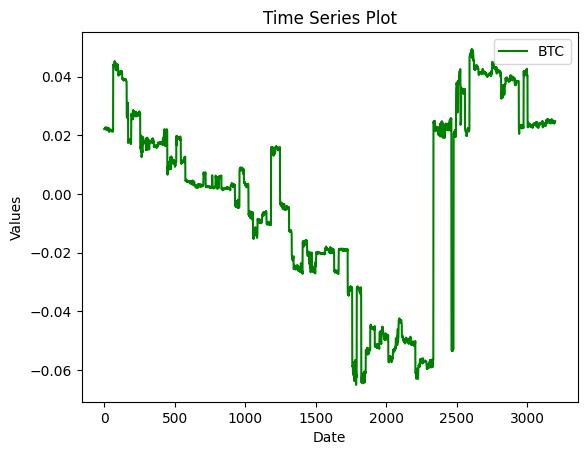

In [332]:
df_trend = pd.DataFrame(X0, columns = crypto_list)

print (len(df_trend))

trend = np.polyfit(np.arange(len(df_trend)), df_trend[crypto_list[3]], 1)
print (trend)

trend_line = np.polyval(trend, np.arange(len(df_trend)))
print (trend_line)

detrended_series = df_trend[crypto_list[3]] - trend_line
print (detrended_series)

fig, ax = plt.subplots()
# # ax.plot(df_trend.index, df_trend[crypto_list[3]], label = crypto_list[3], color = 'blue')
ax.plot(df_trend.index, detrended_series, label = crypto_list[3], color = 'green')
# # ax.plot(df_trend.index, trend_line, label = crypto_list[3], color = 'red')

ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Time Series Plot')
ax.legend()
plt.show()

In [334]:
# 06.05.2024 just helper
values = X_XRP_close.reshape(batch-cnt_thrown_idx, sl)

print (batch-cnt_thrown_idx)
print (values[0])
print (np.mean(values[0]))
print (np.std(values[0]))

100
[0.5185 0.5184 0.5182 0.5184 0.5184 0.5184 0.5184 0.5183 0.5186 0.5194
 0.5187 0.5182 0.5179 0.5177 0.518  0.518  0.5178 0.5179 0.5181 0.5181
 0.5194 0.5181 0.5182 0.5182 0.518  0.5183 0.518  0.518  0.5181 0.5182
 0.5184 0.5192]
0.518296875
0.00040193623172710965


0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 1200x600 with 0 Axes>

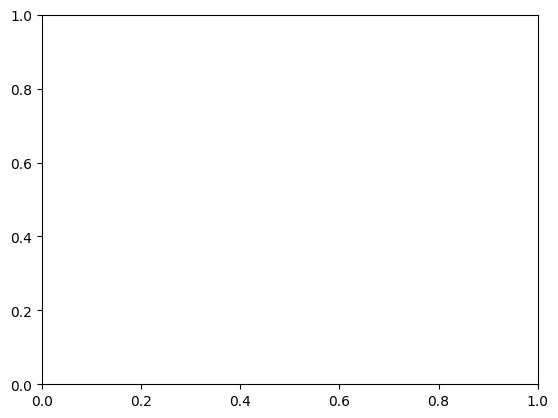

In [83]:
# Figure AutoCorrelations and Partial AutoCorrelations
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i in range(batch-cnt_thrown_idx-1):
    print (i)
# Plot the autocorrelation function (ACF)    
    plt.figure(figsize = (12, 6))
    plot_acf(values[i], lags = sl-1)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()
    
# Plot the partial autocorrelation function (PACF)
    # plt.figure(figsize = (12, 6))
    # plot_pacf(values[round(i/2)], lags = 60)
    # plt.title('Partial Autocorrelation Function (PACF)')
    # plt.show()

In [458]:
n_steps = sl

# model_4f = Sequential()
# model_4f.add(tf.keras.layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (n_steps, n_features)))
# model_4f.add(tf.keras.layers.LSTM(64, activation = 'relu'))
# model_4f.add(tf.keras.layers.Dense(n_features))

# model_4f.compile(optimizer = 'adam', loss = 'mse')

# model_4f.summary()

# fit model
# The number of epochs is the number of complete passes through the training dataset
# history = model_4f.fit(X_detrend, y_detrend, epochs = 100, validation_split = 0.2, verbose = 1)

model_4f = Sequential()
model_4f.add(tf.keras.layers.Input(shape = (n_steps, n_features)))
model_4f.add(tf.keras.layers.LSTM(units = 64, activation = 'relu', return_sequences = True))   
model_4f.add(tf.keras.layers.LSTM(units = 128, activation = 'relu', return_sequences = False))
model_4f.add(tf.keras.layers.Dropout(0.2)) 
model_4f.add(tf.keras.layers.Dense(units = n_out))
# sgd = SGD(clipvalue=1.0)  # Example of gradient clipping
# model_4f.compile(optimizer=sgd, loss='mse')
# sgd = SGD(clipvalue = 1.0, learning_rate = 0.10)
# model_4f.compile(optimizer = sgd, loss = 'mse')
model_4f.compile(optimizer = 'adam', loss = 'mse')
model_4f.summary()

# fit model
# The number of epochs is the number of complete passes through the training dataset
history = model_4f.fit(X_detrend, y_detrend, epochs = 25, 
                       validation_split = 0.2,
                       verbose = 2)
                       # , callbacks=[es])
                       # , callbacks = [TimeStepErrorLogger()])

# # model_8f.add(tf.keras.layers.Dropout(0.2)) 
# model_8f.add(tf.keras.layers.RepeatVector(frwd))
# model_8f.add(tf.keras.layers.LSTM(units = 32, activation = 'relu', return_sequences = True))
# # model_8f.add(tf.keras.layers.Dropout(0.2)) 
# model_8f.add(tf.keras.layers.TimeDistributed(Dense(units = n_out)))

# # Compile the model with MSE loss computed for each time step

# # sgd = SGD(learning_rate = 0.1)
# # model_8f.compile(optimizer = sgd, loss = 'mse')
# model_8f.compile(optimizer = 'adam', loss = 'mean_squared_error')
# model_8f.summary()

# # es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

# # fit model
# # The number of epochs is the number of complete passes through the training dataset
# history = model_8f.fit(X, y, epochs = 500, 
#                        validation_split = 0.2,
#                        verbose = 2)

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_86 (LSTM)                  │ (None, 8, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_87 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,996 (457.02 KB)

 Trainable params: 116,996 (457.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1/1 - 6s - 6s/step - loss: 6.8324e-07 - val_loss: 5.8658e-06
Epoch 2/25
1/1 - 0s - 52ms/step - loss: 5.0636e-06 - val_loss: 7.5421e-07
Epoch 3/25
1/1 - 0s - 50ms/step - loss: 1.0629e-06 - val_loss: 1.6578e-07
Epoch 4/25
1/1 - 0s - 50ms/step - loss: 1.1771e-06 - val_loss: 8.1773e-07
Epoch 5/25
1/1 - 0s - 50ms/step - loss: 1.6545e-06 - val_loss: 6.7781e-07
Epoch 6/25
1/1 - 0s - 50ms/step - loss: 1.7371e-06 - val_loss: 3.7660e-07
Epoch 7/25
1/1 - 0s - 50ms/step - loss: 1.0486e-06 - val_loss: 5.3273e-07
Epoch 8/25
1/1 - 0s - 49ms/step - loss: 1.2801e-06 - val_loss: 4.4379e-07
Epoch 9/25
1/1 - 0s - 51ms/step - loss: 1.3198e-06 - val_loss: 3.6425e-07
Epoch 10/25
1/1 - 0s - 51ms/step - loss: 1.2686e-06 - val_loss: 5.3552e-07
Epoch 11/25
1/1 - 0s - 50ms/step - loss: 1.4923e-06 - val_loss: 6.6236e-07
Epoch 12/25
1/1 - 0s - 49ms/step - loss: 1.1426e-06 - val_loss: 8.7720e-07
Epoch 13/25
1/1 - 0s - 49ms/step - loss: 2.0659e-06 - val_loss: 5.5524e-07
Epoch 14/25
1/1 - 0s - 49ms/step - l

In [99]:
print ("===================================================")
print ("sequence length:  ", sl)

print (batch)
print (cnt_thrown_idx)

print ("batch size:  ", batch-cnt_thrown_idx)
print ("no. of variables:  ", n_features)
print ("no. of predicted variables:  ", n_out)
print ("how many steps forward to predict:  ", frwd)
print ("===================================================")
print ("input shape", X_detrend.shape)
print ("output shape", y_detrend.shape)

sequence length:   132
100
0
batch size:   100
no. of variables:   4
no. of predicted variables:   4
how many steps forward to predict:   10
input shape (100, 132, 4)
output shape (100, 10, 4)


In [100]:
# forward more than one for de-trended model- 07.21.2024
# =======================================================
n_steps = sl

model_8f = Sequential()
model_8f.add(tf.keras.layers.Input(shape = (n_steps, n_features)))
# model_8f.add(tf.keras.layers.LSTM(units = 512, activation = 'relu', return_sequences = False))   


model_8f.add(tf.keras.layers.LSTM(
    units = 512,
    # kernel_initializer = glorot_uniform(),    # Initialize the input weights
    # recurrent_initializer = orthogonal(),     # Initialize the recurrent weights
    # bias_initializer = zeros(),               # Initialize the biases
    activation = 'relu', 
    return_sequences = False
))

# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.RepeatVector(frwd))
model_8f.add(tf.keras.layers.LSTM(units = 256, activation = 'linear', return_sequences = True))
# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.TimeDistributed(Dense(units = n_out)))

# Compile the model with MSE loss computed for each time step

sgd = SGD(learning_rate = 0.1)
model_8f.compile(optimizer = sgd, loss = 'mean_squared_error')
# model_8f.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_8f.summary()

# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

history = model_8f.fit(X_detrend, y_detrend, epochs = 50, validation_split = 0.2, verbose = 2)

# fit model
# The number of epochs is the number of complete passes through the training dataset
# history = model_8f.fit(X_detrend, y_detrend, epochs = 50, 
#                        validation_split = 0.2,
#                        verbose = 2)

2024-07-30 14:45:50.263290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 14:45:50.278393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 14:45:50.282532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 4)          │         1,028 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,847,300 (7.05 MB)

 Trainable params: 1,847,300 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1722350752.262966  130183 service.cc:145] XLA service 0x7fa3e4005a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722350752.263006  130183 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-30 14:45:52.377038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-30 14:45:52.645182: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1722350753.802532  130232 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_69', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1722350754.915767  130227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:17

3/3 - 11s - 4s/step - loss: 1.7780e-05 - val_loss: 9.9707e-05
Epoch 2/50
3/3 - 0s - 56ms/step - loss: 1.8245e-05 - val_loss: 9.9309e-05
Epoch 3/50
3/3 - 0s - 48ms/step - loss: 1.8771e-05 - val_loss: 9.9395e-05
Epoch 4/50
3/3 - 0s - 54ms/step - loss: 2.5997e-05 - val_loss: 1.0007e-04
Epoch 5/50
3/3 - 0s - 53ms/step - loss: 1.6578e-05 - val_loss: 9.9877e-05
Epoch 6/50
3/3 - 0s - 55ms/step - loss: 1.6837e-05 - val_loss: 9.9559e-05
Epoch 7/50
3/3 - 0s - 52ms/step - loss: 2.6779e-05 - val_loss: 1.0016e-04
Epoch 8/50
3/3 - 0s - 48ms/step - loss: 1.6497e-05 - val_loss: 9.9870e-05
Epoch 9/50
3/3 - 0s - 52ms/step - loss: 1.7247e-05 - val_loss: 9.9434e-05
Epoch 10/50
3/3 - 0s - 52ms/step - loss: 1.8018e-05 - val_loss: 9.9242e-05
Epoch 11/50
3/3 - 0s - 56ms/step - loss: 1.6740e-05 - val_loss: 9.8912e-05
Epoch 12/50
3/3 - 0s - 51ms/step - loss: 1.7397e-05 - val_loss: 9.8639e-05
Epoch 13/50
3/3 - 0s - 50ms/step - loss: 1.7514e-05 - val_loss: 9.8309e-05
Epoch 14/50
3/3 - 0s - 55ms/step - loss: 1.675

In [101]:
print ("input shape", X_detrend.shape)
print ("output shape", y_detrend.shape)

input shape (100, 132, 4)
output shape (100, 10, 4)


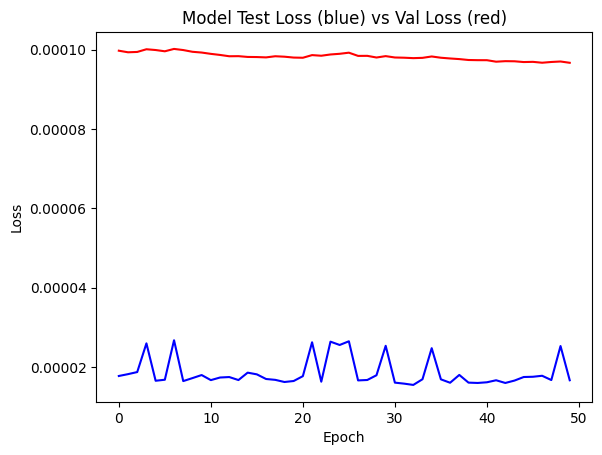

In [102]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1)

# Plot the data
ax.plot(history.history['loss'], 'blue')
ax.plot(history.history['val_loss'], 'red')

# Customize the plot
ax.set_title('Model Test Loss (blue) vs Val Loss (red)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.show()

In [162]:
# Extract weights from the LSTM layer
lstm_layer = model_4f.layers[0]
lstm_weights = lstm_layer.get_weights()

In [251]:
kernel, recurrent_kernel, bias = lstm_weights

# Print the shapes
print(f"Kernel shape: {kernel.shape}")
print(f"Recurrent Kernel shape: {recurrent_kernel.shape}")
print(f"Bias shape: {bias.shape}")

Kernel shape: (4, 8)
Recurrent Kernel shape: (2, 8)
Bias shape: (8,)


In [164]:
# Print the weights
print("Kernel weights:", kernel)
print("Recurrent kernel weights:", recurrent_kernel)
print("Bias weights:", bias)

Kernel weights: [[-0.29570043 -0.5004754   0.20667636  0.10042548  0.53247315  0.3485367
   0.06583369  0.30498368]
 [-0.0952394   0.6267162  -0.5430347  -0.11614949 -0.14094801  0.45296112
   0.46237165 -0.5539824 ]
 [-0.6704555  -0.32267913 -0.02672264 -0.01044066 -0.55034953 -0.5247029
  -0.39970452 -0.2879326 ]
 [-0.4440828  -0.69091105  0.5708396  -0.62216336  0.01680009  0.60691565
   0.504008   -0.2612597 ]]
Recurrent kernel weights: [[-0.48168886  0.55765843 -0.29909894 -0.32422814 -0.07709108  0.16607761
  -0.40783387 -0.2501138 ]
 [-0.4924853  -0.33605534  0.23202763  0.33475357 -0.5284006   0.42610377
   0.03789801 -0.12824975]]
Bias weights: [-1.3965615e-05 -1.7603061e-06  9.9997938e-01  9.9999720e-01
 -1.3367771e-03 -2.4126284e-05 -1.4065922e-05 -1.7748447e-06]


In [114]:
#  Validation Set - Helper

# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 2  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_valid['Selected'] = 0


# Trimming Indices !!!
# Marking selected rows
sample_valid.loc[:, 'Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

sample_valid.loc[selected_indices, 'Selected'] = 1 

chosen_idx = sample_valid[sample_valid['Selected'] == 1].index

cnt_thrown_idx1 = 0
cnt_thrown_idx2 = 0

for idx in chosen_idx:    
    if (idx-(sl-1) < 0):
       # print ('scratch index on a left:  ', idx)
       cnt_thrown_idx1 = cnt_thrown_idx1 + 1
       # print ('cnt_thrown_idx1:  ', cnt_thrown_idx1)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

for idx in chosen_idx:
    if (idx+(frwd+1) > sample_size):
       # print ('scratch index on a right:  ', idx)
       cnt_thrown_idx2 = cnt_thrown_idx2 + 1
       # print ('cnt_thrown_idx2:  ', cnt_thrown_idx2)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print ('cnt_thrown_idx = ', cnt_thrown_idx)

sample_size:  10503
cnt_thrown_idx =  0


In [115]:
# De-Trend Model
# variables are close and volume

#  Validation Set - 07.21.2024
# ============================
# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 2  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict

## Trimming Indices !!!
# Marking selected rows
sample_valid.loc[:, 'Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

sample_valid.loc[selected_indices, 'Selected'] = 1 

chosen_idx = sample_valid[sample_valid['Selected'] == 1].index

cnt_thrown_idx1 = 0
cnt_thrown_idx2 = 0

for idx in chosen_idx:    
    if (idx-(sl-1) < 0):
       # print ('scratch index on a left:  ', idx)
       cnt_thrown_idx1 = cnt_thrown_idx1 + 1
       # print ('cnt_thrown_idx1:  ', cnt_thrown_idx1)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

for idx in chosen_idx:
    if (idx+(frwd+1) > sample_size):
       # print ('scratch index on a right:  ', idx)
       cnt_thrown_idx2 = cnt_thrown_idx2 + 1
       # print ('cnt_thrown_idx2:  ', cnt_thrown_idx2)
       chosen_idx = chosen_idx.drop(idx)
       # print (chosen_idx)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print ('cnt_thrown_idx = ', cnt_thrown_idx)

print ('Selected Indices: ')
print (selected_indices)
# print ('=============================================')

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

# print (all_ts_close_btc)
# print (aft_ts_close_btc)

for idx in chosen_idx:
  selected_rows_before = sample_valid.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_valid.iloc[max(0, idx): idx+frwd]
  # print ('idx:  ', idx)

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  

# Compute the weighted average
  weighted_avg_xrp = np.average(sr_after_close_xrp, weights = sr_after_volume_xrp)
  # print ('XRP w.average:  ', weighted_avg_xrp)

# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])

# Compute the weighted average
  weighted_avg_eth = np.average(sr_after_close_eth, weights = sr_after_volume_eth)
  # print ('ETH w.average:  ', weighted_avg_eth)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])

# Compute the weighted average
  weighted_avg_ltc = np.average(sr_after_close_ltc, weights = sr_after_volume_ltc)
  # print ('LTC w.average:  ', weighted_avg_ltc)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])

# Compute the weighted average
  weighted_avg_btc = np.average(sr_after_close_btc, weights = sr_after_volume_btc)
  # print ('BTC w.average:  ', weighted_avg_btc)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))

  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))

X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]

X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]

# X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
#                       X_ETH_close, X_ETH_volume, 
#                       X_LTC_close, X_LTC_volume, 
#                       X_BTC_close, X_BTC_volume))

X0_valid = np.column_stack((X_XRP_close,
                            X_ETH_close,
                            X_LTC_close,
                            X_BTC_close))
# print (X0)

# ======== Model Input =========
X_valid = X0_valid.reshape(batch_valid-cnt_thrown_idx, sl, n_features)
# print ('================ original series =================')    
# print ('XXXX ====== Actual Input ====== XXXX')
# print (X)
# print (X.shape)

print ('================== trend lines ===================')   

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]
# print ('y_BTC:  ', y_BTC)

y_valid = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y)

y_valid = y_valid.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
# print (y)
# print (y.shape)

def detrend_series(series):
    trend = np.polyfit(np.arange(len(series)), series.values, 1)
    trend_line = np.polyval(trend, np.arange(len(series)))
    detrended_series = series - trend_line
    return detrended_series

crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']

X_valid_trend = np.zeros((batch_valid-cnt_thrown_idx, sl, n_features))
# print ('X_trend')
# print (X_trend)

X_valid_detrend = np.zeros((batch_valid-cnt_thrown_idx, sl, n_features))
# print ('X_detrend')
# print (X_detrend)

y_valid_trend = np.zeros((batch_valid-cnt_thrown_idx, frwd, n_out))
# print ('y_trend')
# print (y_trend)

for j in range(batch_valid-cnt_thrown_idx):
    # print ('      ')
    # print ('     j = ', j)
    df_trend = pd.DataFrame(X_valid[j], columns = crypto_list)
    # print ('df_trend:  ', df_trend)
 
# XRP
    coef_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
    print ("coef_xrp:  ", coef_xrp) 
    trend_line_xrp = np.polyval(coef_xrp, np.arange(len(df_trend)))
    detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
    detrend_xrp = detrended_series_xrp.to_numpy()  

    y_xrp_trend = np.empty(frwd)
    # print ('y_xrp_trend:  ', y_xrp_trend)
    for f in range(frwd):
        y_xrp_trend[f] = coef_xrp[0]*(len(df_trend)+f) + coef_xrp[1] 
        print (y_xrp_trend[f])

    # ETH
    coef_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
    print ("coef_eth:  ", coef_eth)
    trend_line_eth = np.polyval(coef_eth, np.arange(len(df_trend)))
    detrended_series_eth = df_trend['ETH'] - trend_line_eth
    detrend_eth = detrended_series_eth.to_numpy()

    y_eth_trend = np.empty(frwd)
    # print ('y_eth_trend:  ', y_eth_trend)
    for f in range(frwd):
        y_eth_trend[f] = coef_eth[0]*(len(df_trend)+f) + coef_eth[1] 
        print (y_eth_trend[f])
  
# LTC    
    coef_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
    print ("coef_ltc:  ", coef_ltc)
    trend_line_ltc = np.polyval(coef_ltc, np.arange(len(df_trend)))
    detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
    detrend_ltc = detrended_series_ltc.to_numpy()

    y_ltc_trend = np.empty(frwd)
    # print ('y_ltc_trend:  ', y_ltc_trend)
    for f in range(frwd):
        y_ltc_trend[f] = coef_ltc[0]*(len(df_trend) + f) + coef_ltc[1] 
        print (y_ltc_trend[f])

# BTC    
    coef_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
    # print ('df_trend[BTC]:   ', df_trend['BTC'])
    print ("coef_btc:  ", coef_btc)
    trend_line_btc = np.polyval(coef_btc, np.arange(len(df_trend)))
    detrended_series_btc = df_trend['BTC'] - trend_line_btc
    detrend_btc = detrended_series_btc.to_numpy()

    y_btc_trend = np.empty(frwd)
    
    print ('y_btc_trend:  ', y_btc_trend)
    
    for f in range(frwd):
        
        y_btc_trend[f] = coef_btc[0]*(len(df_trend) + f) + coef_btc[1] 
        print ('f:  ', f)
        print (len(df_trend) + f)
        print (y_btc_trend[f])
        

    # print ('y_btc_trend:  ', y_btc_trend)
    # print ('type of y_btc_trend:  ', type (y_btc_trend))
        
    # Create a dictionary with the data
    trend_dict = {'XRP' : trend_line_xrp, 
                  'ETH' : trend_line_eth, 
                  'LTC' : trend_line_ltc, 
                  'BTC' : trend_line_btc
                 }
    df = pd.DataFrame(trend_dict)
    
    # Fill the DataFrame column by column
    for col, values in trend_dict.items():
        df[col] = values
    
    X0_valid_trend = df.to_numpy()
 
    X_valid_trend[j] += X0_valid_trend 

    detrend_dict = {'XRP' : detrend_xrp, 
                    'ETH' : detrend_eth, 
                    'LTC' : detrend_ltc, 
                    'BTC' : detrend_btc
                   }
    
    df = pd.DataFrame(detrend_dict)

    # Fill the DataFrame column by column
    for col, values in detrend_dict.items():
        df[col] = values

    X0_valid_detrend = df.to_numpy()

    X_valid_detrend[j] += X0_valid_detrend 
    
    # Create a dictionary with the data
    # y_trend_dict = {'XRP' : np.array([y_xrp_trend]), 
    #                 'ETH' : np.array([y_eth_trend]), 
    #                 'LTC' : np.array([y_ltc_trend]), 
    #                 'BTC' : np.array([y_btc_trend])
    #                }

    # Create a dictionary with the data
    y_valid_trend_dict = {'XRP' : y_xrp_trend, 
                          'ETH' : y_eth_trend, 
                          'LTC' : y_ltc_trend, 
                          'BTC' : y_btc_trend
                         }
    # print (y_valid_trend_dict)

    df1 = pd.DataFrame(y_valid_trend_dict)

    # print (' df1 ')
    # print (df1)
    # print (df1.shape)
    # print ('  ')
    
    # Fill the DataFrame column by column
    for key, value in y_valid_trend_dict.items():
        # print(f"{key}: {value}")
        df1[key] = value

    y_valid_tr = df1.to_numpy()
    y_valid_trend[j] += y_valid_tr

print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid)
print (y_valid.shape)

print ('YYYY ====== Trend Input ======= YYYY')
print (y_valid_trend)
print (type(y_valid_trend))
print (y_valid_trend.shape)

print ('YYYY ====== De-Trend Input ======= YYYY')
y_valid_detrend = y_valid - y_valid_trend
print (y_valid_detrend)
# print (type(y_detrend))
# print (y_detrend.shape)


sample_size:  10503
cnt_thrown_idx =  0
Selected Indices: 
[1043  948]
================== trend lines ===================
coef_xrp:   [-1.05565788e-05  4.80812668e-01]
0.4794191996298865
0.47940864305106956
0.4793980864722526
0.47938752989343575
0.4793769733146188
0.4793664167358019
0.47935586015698495
0.479345303578168
0.4793347469993511
0.47932419042053415
coef_eth:   [-8.99630061e-06  3.46768409e-01]
0.345580897524867
0.3455719012242612
0.3455629049236554
0.34555390862304963
0.34554491232244383
0.34553591602183803
0.3455269197212323
0.3455179234206265
0.3455089271200207
0.34549993081941494
coef_ltc:   [-1.38826421e-05  7.45367646e-01]
0.7435351376359008
0.7435212549938341
0.7435073723517674
0.7434934897097009
0.7434796070676342
0.7434657244255676
0.7434518417835009
0.7434379591414342
0.7434240764993676
0.7434101938573009
coef_btc:   [-2.24646653e-06  6.27287325e-01]
y_btc_trend:   [7.25456054e-316 0.00000000e+000 6.93407703e-310 0.00000000e+000
 1.48219694e-323 0.00000000e+000 0.000

In [116]:
print (X_valid_trend)

[[[0.48081267 0.34676841 0.74536765 0.62728732]
  [0.48080211 0.34675941 0.74535376 0.62728508]
  [0.48079155 0.34675042 0.74533988 0.62728283]
  ...
  [0.47945087 0.34560789 0.74357679 0.62699753]
  [0.47944031 0.34559889 0.7435629  0.62699528]
  [0.47942976 0.34558989 0.74354902 0.62699304]]

 [[0.47973929 0.34593499 0.74422297 0.62660939]
  [0.47973287 0.3459427  0.74424625 0.62664506]
  [0.47972646 0.34595041 0.74426952 0.62668073]
  ...
  [0.47891142 0.34692942 0.74722593 0.63121093]
  [0.478905   0.34693713 0.74724921 0.6312466 ]
  [0.47889859 0.34694484 0.74727249 0.63128227]]]


In [ ]:
'''erase later'''

In [364]:
#  Validation Set - 06.20.2024
# ============================
# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 10  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_valid['Selected'] = 0

# =============================================

# Selecting m random rows without replacement
np.random.seed(37)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

print ('selected_indices:  ', selected_indices)
print ('sequence length:  ', sl)

sample_valid.loc[selected_indices, 'Selected'] = 1 

chosen_idx1 = sample_valid[sample_valid['Selected'] == 1].index
print ('chosen_idx1:   ', chosen_idx1)

chosen_idx2 = chosen_idx1[chosen_idx1 > sl]
print ('chosen_idx2:   ', chosen_idx2)


thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)
print ('thrown_idx1:   ', thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]
print ('chosen_idx3:   ', chosen_idx3)


thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2
print ('cnt_thrown_idx:   ', cnt_thrown_idx)

print (selected_indices)

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output

aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
# Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
# Compute the weighted average
  weighted_avg_xrp = np.average(sr_after_close_xrp, weights = sr_after_volume_xrp)
  # print ('XRP w.average:  ', weighted_avg_xrp)

# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
# Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
# Compute the weighted average
  weighted_avg_eth = np.average(sr_after_close_eth, weights = sr_after_volume_eth)
  # print ('ETH w.average:  ', weighted_avg_eth)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
# Compute the weighted average
  weighted_avg_ltc = np.average(sr_after_close_ltc, weights = sr_after_volume_ltc)
  # print ('LTC w.average:  ', weighted_avg_ltc)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
# Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
# Compute the weighted average
  weighted_avg_btc = np.average(sr_after_close_btc, weights = sr_after_volume_btc)
  # print ('BTC w.average:  ', weighted_avg_btc)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))

  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))

X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

# X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
#                       X_ETH_close, X_ETH_volume, 
#                       X_LTC_close, X_LTC_volume, 
#                       X_BTC_close, X_BTC_volume))

X0 = np.column_stack((X_XRP_close,
                      X_ETH_close,
                      X_LTC_close,
                      X_BTC_close))
# print (X0)

# ======== Model Input =========
X_valid = X0.reshape(batch_valid-cnt_thrown_idx, sl, n_features)

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

y_valid = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y_valid)

y_valid = y_valid.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid.shape)

# def detrend_series(series):
#     trend = np.polyfit(np.arange(len(series)), series.values, 1)
#     trend_line = np.polyval(trend, np.arange(len(series)))
#     detrended_series = series - trend_line
#     return detrended_series

crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']
X_valid_trend = np.zeros((batch_valid-cnt_thrown_idx, sl, n_features))
# print (X_trend)
X_valid_detrend = np.zeros((batch_valid-cnt_thrown_idx, sl, n_features))
# print (X_detrend)
y_valid_trend = np.zeros((batch_valid-cnt_thrown_idx, frwd, n_out))
# print (y_trend)
for j in range(batch_valid-cnt_thrown_idx):
    df_trend = pd.DataFrame(X_valid[j], columns = crypto_list)
    # print (df_trend)
    print (j)
# XRP
    coef_xrp = np.polyfit(np.arange(len(df_trend)), df_trend['XRP'], 1)
    # print ("coef_xrp:  ", coef_xrp)     #  coef_xrp:   [-0.00074848  0.48839818]
    trend_line_xrp = np.polyval(coef_xrp, np.arange(len(df_trend)))
    detrended_series_xrp = df_trend['XRP'] - trend_line_xrp
    detrend_xrp = detrended_series_xrp.to_numpy()  

    y_xrp_trend = coef_xrp[0]*(len(df_trend)) + coef_xrp[1]
    
# ETH
    coef_eth = np.polyfit(np.arange(len(df_trend)), df_trend['ETH'], 1)
    # print ("coef_eth:  ", coef_eth)
    trend_line_eth = np.polyval(coef_eth, np.arange(len(df_trend)))
    detrended_series_eth = df_trend['ETH'] - trend_line_eth
    detrend_eth = detrended_series_eth.to_numpy()

    y_eth_trend = coef_eth[0]*(len(df_trend)) + coef_eth[1]
    
# LTC    
    coef_ltc = np.polyfit(np.arange(len(df_trend)), df_trend['LTC'], 1)
    # print ("coef_ltc:  ", coef_ltc)
    trend_line_ltc = np.polyval(coef_ltc, np.arange(len(df_trend)))
    detrended_series_ltc = df_trend['LTC'] - trend_line_ltc
    detrend_ltc = detrended_series_ltc.to_numpy()
    
    y_ltc_trend = coef_ltc[0]*(len(df_trend)) + coef_ltc[1]

# BTC    
    coef_btc = np.polyfit(np.arange(len(df_trend)), df_trend['BTC'], 1)
    # print ("coef_btc:  ", coef_btc)
    trend_line_btc = np.polyval(coef_btc, np.arange(len(df_trend)))
    detrended_series_btc = df_trend['BTC'] - trend_line_btc
    detrend_btc = detrended_series_btc.to_numpy()


    # print ('df_trend:  ', df_trend)
    # print ('trend_line_btc:   ', trend_line_btc)
    # print ('detrended_series_btc:   ', detrended_series_btc)
    # print ('detrend_btc:   ', detrend_btc)
    
    y_btc_trend = coef_btc[0]*(len(df_trend)) + coef_btc[1]

    # print (X[j])
    # print (type(X[j]))
    # print (X[j].shape)
    # print ('==================================================')
        
    # Create a dictionary with the data
    trend_dict = {'XRP' : trend_line_xrp, 
                  'ETH' : trend_line_eth, 
                  'LTC' : trend_line_ltc, 
                  'BTC' : trend_line_btc
                 }
    df = pd.DataFrame(trend_dict)
    
    # Fill the DataFrame column by column
    for col, values in trend_dict.items():
        df[col] = values
    
    X0_valid_trend = df.to_numpy()
    # print (X0_trend)
    # print (type(X0_trend))
    # print (X0_trend.shape)

    X_valid_trend[j] += X0_valid_trend 

    detrend_dict = {'XRP' : detrend_xrp, 
                    'ETH' : detrend_eth, 
                    'LTC' : detrend_ltc, 
                    'BTC' : detrend_btc
                   }
    # print ('detrend_dict')
    # print (detrend_dict)
    
    df = pd.DataFrame(detrend_dict)

    # Fill the DataFrame column by column
    for col, values in detrend_dict.items():
        df[col] = values

    X0_valid_detrend = df.to_numpy()
    # print (X0_detrend)
    # print (type(X0_detrend))
    # print (X0_detrend.shape)

    X_valid_detrend[j] += X0_valid_detrend 
    
    # print ('================ originalseries ==================')    
    # print (X)
    # print (type(X))
    # print (X_trend.shape)
    
    # print ('================== trend lines ===================')    
    # print (X_trend)
    # print (type(X_trend))
    # print (X_trend.shape)
    
    # print ('================== fluctuations ===================')    
    # print (X_detrend)
    # print (type(X_detrend))
    # print (X_detrend.shape)

    # print ('y_xrp_trend:  ', y_xrp_trend)
    # print ('y_eth_trend:  ', y_eth_trend)
    # print ('y_ltc_trend:  ', y_ltc_trend)
    # print ('y_btc_trend:  ', y_btc_trend)

    # print (type(y_xpr_trend))
    # print (y_xpr_trend.shape)

    # Create a dictionary with the data
    y_trend_dict = {'XRP' : np.array([y_xrp_trend]), 
                    'ETH' : np.array([y_eth_trend]), 
                    'LTC' : np.array([y_ltc_trend]), 
                    'BTC' : np.array([y_btc_trend])
                   }
    # print (y_trend_dict)

    df1 = pd.DataFrame(y_trend_dict)
   
    # Fill the DataFrame column by column
    for key, value in y_trend_dict.items():
        # print(f"{key}: {value}")
        df1[key] = value

    y_valid_tr = df1.to_numpy()
    y_valid_trend[j] += y_valid_tr

print ('================ original series =================')    
print (X_valid)
print (type(X_valid))
print (X_valid.shape)

print ('================== trend lines ===================')    
print (X_valid_trend)
print (type(X_valid_trend))
print (X_valid_trend.shape)

print ('================== fluctuations ===================')    
print (X_valid_detrend)
print (type(X_valid_detrend))
print (X_valid_detrend.shape)

print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid)
print (y_valid.shape)

print ('YYYY ====== Trend Input ======= YYYY')
print (y_valid_trend)
print (type(y_valid_trend))
print (y_valid_trend.shape)

print ('YYYY ====== De-Trend Input ======= YYYY')
y_valid_detrend = y_valid - y_valid_trend
print (y_valid_detrend)
print (type(y_valid_detrend))
print (y_valid_detrend.shape)


sample_size:  10503
selected_indices:   [ 8150  6285  9376  5205  9639  2760  6835 10459  8493  1643]
sequence length:   32
chosen_idx1:    Index([1643, 2760, 5205, 6285, 6835, 8150, 8493, 9376, 9639, 10459], dtype='int64')
chosen_idx2:    Index([1643, 2760, 5205, 6285, 6835, 8150, 8493, 9376, 9639, 10459], dtype='int64')
thrown_idx1:    Index([], dtype='int64')
chosen_idx3:    Index([1643, 2760, 5205, 6285, 6835, 8150, 8493, 9376, 9639, 10459], dtype='int64')
cnt_thrown_idx:    0
[ 8150  6285  9376  5205  9639  2760  6835 10459  8493  1643]
(10, 1, 4)
0
1
2
3
4
5
6
7
8
9
================ original series =================
[[[0.4981    0.367673  0.7941    0.6941372]
  [0.498     0.3677    0.7938    0.6941192]
  [0.4977    0.367632  0.7936    0.6942   ]
  ...
  [0.4966    0.367292  0.792     0.6934778]
  [0.4965    0.367265  0.7922    0.6935041]
  [0.4975    0.367529  0.7932    0.693982 ]]

 [[0.495     0.366019  0.7935    0.6934182]
  [0.495     0.365843  0.7935    0.6932386]
  [0.4947 

In [117]:
y_valid_detrend = y_valid_detrend.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
print ('y_valid_detrend')
print (type(y_valid_detrend))
print (y_valid_detrend.shape)
print (y_valid_detrend)
# print (y_valid[0:10])

y_hat_detrend = model_8f.predict(X_valid_detrend, verbose = 1)
print ('y_hat_detrend')
print (type(y_hat_detrend))
print (y_hat_detrend.shape)
print (y_hat_detrend)
# y_hat_detrend.reshape(batch_valid-cnt_thrown_idx, frwd)
# print (sl)

y_valid_detrend
<class 'numpy.ndarray'>
(2, 10, 4)
[[[ 1.18080037e-03  4.29102475e-04  1.64862364e-04  6.87089637e-05]
  [ 1.39135695e-03  5.60098776e-04  5.78745006e-04  3.79555430e-04]
  [ 1.50191353e-03  5.99095076e-04  4.92627648e-04  3.48601897e-04]
  [ 3.12470107e-04  8.81091377e-04  1.60651029e-03  3.07348363e-04]
  [ 2.23026685e-04  9.72087678e-04  1.32039293e-03  5.59794830e-04]
  [ 1.13358326e-03  1.55108398e-03  2.93427557e-03  1.99434130e-03]
  [ 1.84413984e-03  1.61708028e-03  3.34815822e-03  1.97678776e-03]
  [ 1.65469642e-03  1.67107658e-03  3.06204086e-03  1.96203423e-03]
  [ 2.26525300e-03  1.68907288e-03  3.67592350e-03  2.16898070e-03]
  [ 2.57580958e-03  1.72106918e-03  3.28980614e-03  2.38972716e-03]]

 [[ 4.07830211e-04 -3.05547999e-04  8.04233171e-04  5.40261716e-04]
  [ 1.14247799e-04 -6.22256741e-04  6.80954381e-04 -7.69091145e-05]
  [-3.79334613e-04 -6.42965483e-04 -2.24232441e-03 -1.96407995e-03]
  [-3.72917025e-04 -6.26674225e-04  2.34396800e-04 -2.77350776e

In [118]:
print ('y_valid_detrend')
print (y_valid_detrend[0])
print ('')
print ('y_hat_detrend')
print (y_hat_detrend[0])

y_valid_detrend
[[1.18080037e-03 4.29102475e-04 1.64862364e-04 6.87089637e-05]
 [1.39135695e-03 5.60098776e-04 5.78745006e-04 3.79555430e-04]
 [1.50191353e-03 5.99095076e-04 4.92627648e-04 3.48601897e-04]
 [3.12470107e-04 8.81091377e-04 1.60651029e-03 3.07348363e-04]
 [2.23026685e-04 9.72087678e-04 1.32039293e-03 5.59794830e-04]
 [1.13358326e-03 1.55108398e-03 2.93427557e-03 1.99434130e-03]
 [1.84413984e-03 1.61708028e-03 3.34815822e-03 1.97678776e-03]
 [1.65469642e-03 1.67107658e-03 3.06204086e-03 1.96203423e-03]
 [2.26525300e-03 1.68907288e-03 3.67592350e-03 2.16898070e-03]
 [2.57580958e-03 1.72106918e-03 3.28980614e-03 2.38972716e-03]]

y_hat_detrend
[[-5.6653440e-05  2.5433156e-04 -3.4374790e-04  6.9114962e-04]
 [-5.9690712e-05  2.6803385e-04 -3.2215202e-04  8.2256412e-04]
 [-6.4747786e-05  2.8194470e-04 -2.9735584e-04  9.2082750e-04]
 [-7.1143615e-05  2.9463111e-04 -2.7235615e-04  9.9390594e-04]
 [-7.8246012e-05  3.0545046e-04 -2.4885271e-04  1.0477444e-03]
 [-8.5539577e-05  3.142

In [ ]:
''' help with pictures - only BTC 07.23.2024 '''

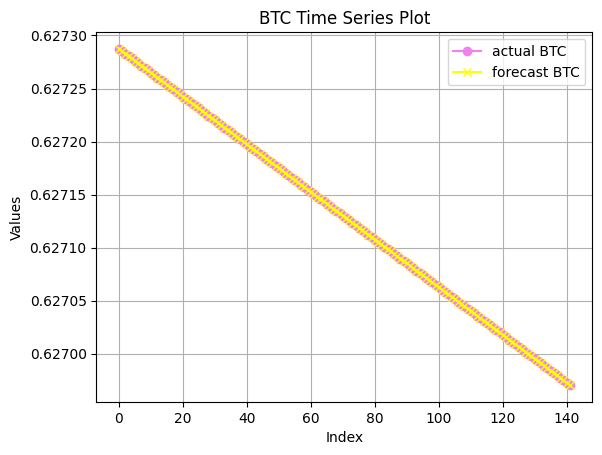

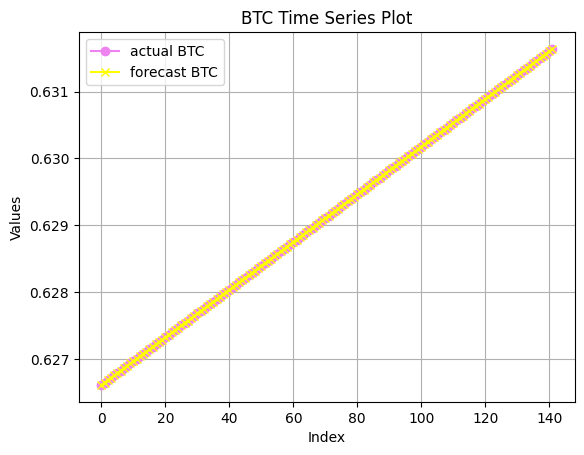

In [122]:
for i in range(batch_valid-cnt_thrown_idx):
    actual = pd.concat([pd.DataFrame(X_valid_trend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                        pd.DataFrame(y_valid_trend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                        ignore_index = True)
    # print(actual)
    forecast = pd.concat([pd.DataFrame(X_valid_trend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                          pd.DataFrame(y_valid_trend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                          ignore_index = True)
    # print(forecast)

# =================== BTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['BTC'], label = 'actual BTC', marker = 'o', color = 'violet')
    ax.plot(forecast.index, forecast['BTC'], label = 'forecast BTC', marker = 'x', color = 'yellow')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('BTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()

          XRP       ETH       LTC       BTC
0   -0.000313 -0.000489  0.002632 -0.000033
1   -0.000002  0.000266  0.001046  0.000648
2   -0.000192 -0.000071  0.000260  0.000109
3    0.000019  0.000007  0.000574  0.000271
4    0.000030  0.000195  0.000788  0.000629
..        ...       ...       ...       ...
137  0.001134  0.001551  0.002934  0.001994
138  0.001844  0.001617  0.003348  0.001977
139  0.001655  0.001671  0.003062  0.001962
140  0.002265  0.001689  0.003676  0.002169
141  0.002576  0.001721  0.003290  0.002390

[142 rows x 4 columns]
          XRP       ETH       LTC       BTC
0   -0.000313 -0.000489  0.002632 -0.000033
1   -0.000002  0.000266  0.001046  0.000648
2   -0.000192 -0.000071  0.000260  0.000109
3    0.000019  0.000007  0.000574  0.000271
4    0.000030  0.000195  0.000788  0.000629
..        ...       ...       ...       ...
137 -0.000086  0.000314 -0.000228  0.001087
138 -0.000093  0.000321 -0.000209  0.001115
139 -0.000099  0.000326 -0.000194  0.001134
140 -0.0

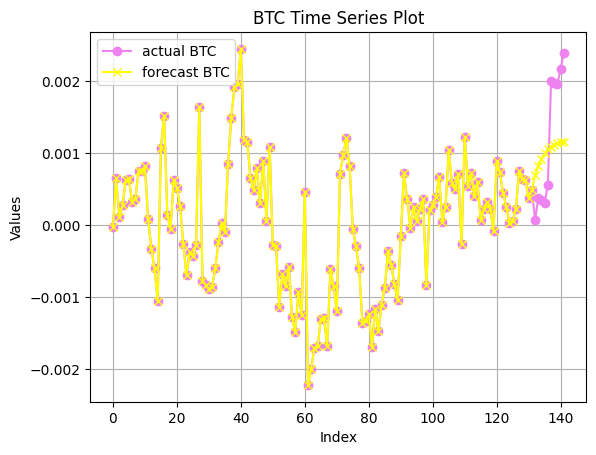

          XRP       ETH       LTC       BTC
0   -0.000539 -0.000311 -0.001023  0.000514
1   -0.000233 -0.000194  0.000054  0.000653
2   -0.000326 -0.000242 -0.000170  0.000745
3   -0.000020 -0.000359 -0.001093 -0.000475
4   -0.000414 -0.000310 -0.000416  0.000526
..        ...       ...       ...       ...
137 -0.000260 -0.000562 -0.000012 -0.000517
138 -0.000254 -0.000772 -0.000235 -0.000856
139 -0.000247 -0.000652  0.000041 -0.000612
140 -0.000341 -0.000600  0.000118 -0.000651
141 -0.000234 -0.000769  0.000095 -0.000985

[142 rows x 4 columns]
          XRP       ETH       LTC       BTC
0   -0.000539 -0.000311 -0.001023  0.000514
1   -0.000233 -0.000194  0.000054  0.000653
2   -0.000326 -0.000242 -0.000170  0.000745
3   -0.000020 -0.000359 -0.001093 -0.000475
4   -0.000414 -0.000310 -0.000416  0.000526
..        ...       ...       ...       ...
137 -0.000154  0.000193 -0.000413  0.000967
138 -0.000166  0.000192 -0.000407  0.000988
139 -0.000177  0.000191 -0.000401  0.001002
140 -0.0

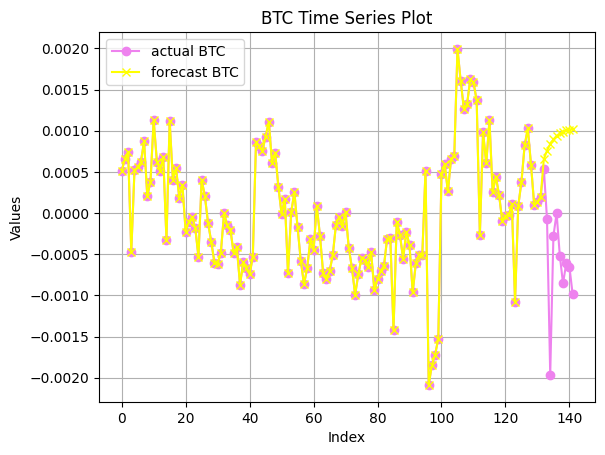

In [123]:
for i in range(batch_valid-cnt_thrown_idx):
    actual = pd.concat([pd.DataFrame(X_valid_detrend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                        pd.DataFrame(y_valid_detrend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                        ignore_index = True)
    print(actual)
    forecast = pd.concat([pd.DataFrame(X_valid_detrend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                          pd.DataFrame(y_hat_detrend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                          ignore_index = True)
    print(forecast)

# =================== BTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['BTC'], label = 'actual BTC', marker = 'o', color = 'violet')
    ax.plot(forecast.index, forecast['BTC'], label = 'forecast BTC', marker = 'x', color = 'yellow')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('BTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()

0


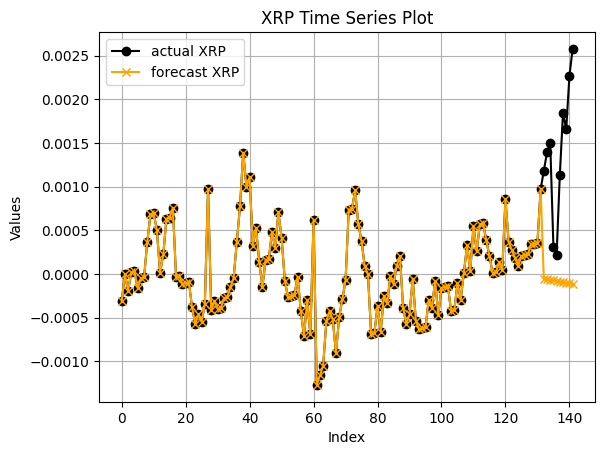

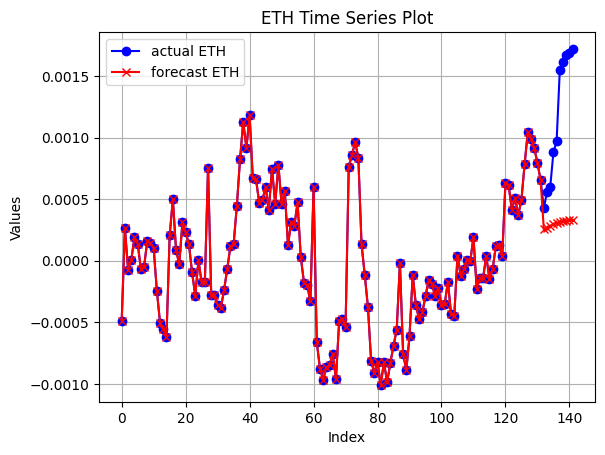

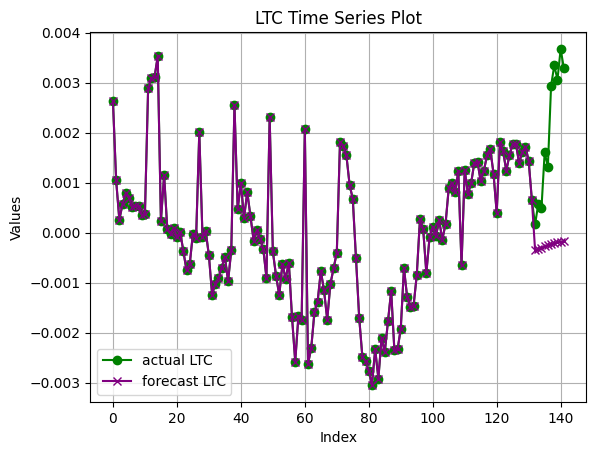

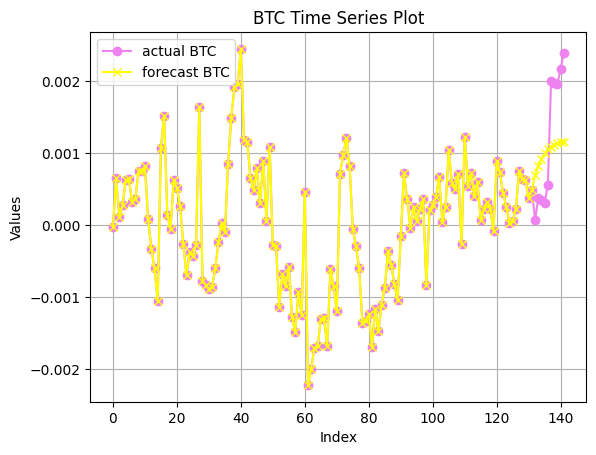

1


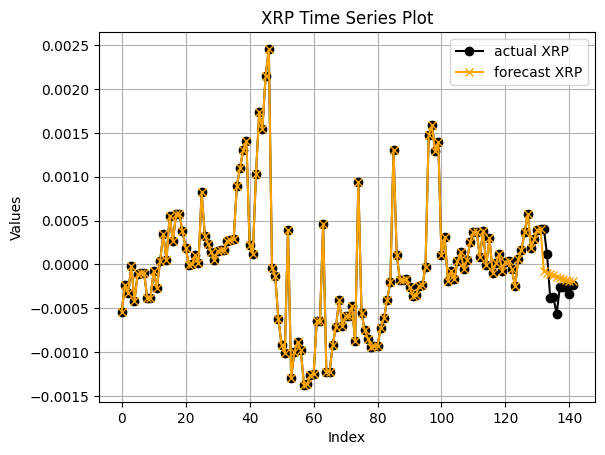

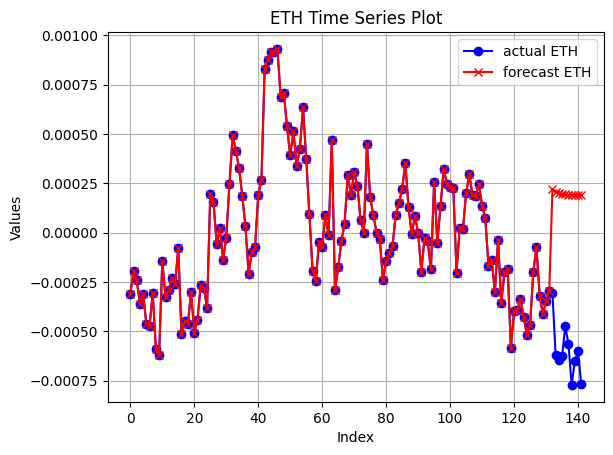

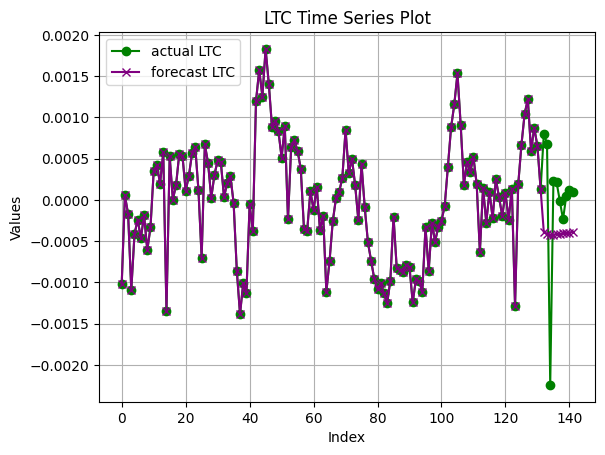

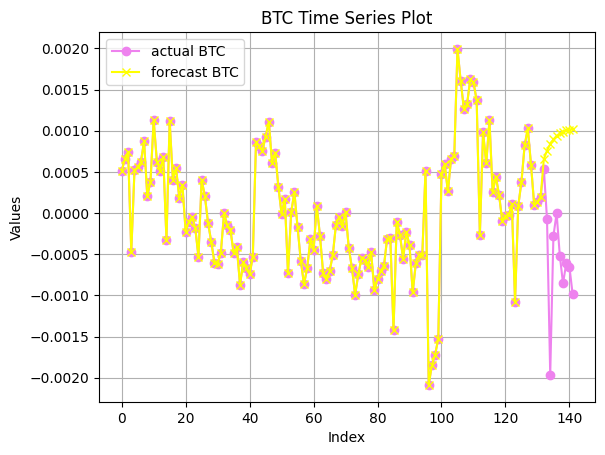

In [124]:
for i in range(batch_valid-cnt_thrown_idx):
    actual = pd.concat([pd.DataFrame(X_valid_detrend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                        pd.DataFrame(y_valid_detrend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                        ignore_index = True)
    # print(actual)
    forecast = pd.concat([pd.DataFrame(X_valid_detrend[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                          pd.DataFrame(y_hat_detrend[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                          ignore_index = True)
    # print(forecast)
    print (i)
# =================== XPR ======================== 
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['XRP'], label = 'actual XRP', marker = 'o', color = 'black')
    ax.plot(forecast.index, forecast['XRP'], label = 'forecast XRP', marker = 'x', color = 'orange')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('XRP Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== ETH ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['ETH'], label = 'actual ETH', marker = 'o', color = 'blue')
    ax.plot(forecast.index, forecast['ETH'], label = 'forecast ETH', marker = 'x', color = 'red')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('ETH Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== LTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['LTC'], label = 'actual LTC', marker = 'o', color = 'green')
    ax.plot(forecast.index, forecast['LTC'], label = 'forecast LTC', marker = 'x', color = 'purple')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('LTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== BTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['BTC'], label = 'actual BTC', marker = 'o', color = 'violet')
    ax.plot(forecast.index, forecast['BTC'], label = 'forecast BTC', marker = 'x', color = 'yellow')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('BTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()

In [ ]:
# 07.16.2024
# add trend back

In [125]:
y_valid_trend = y_valid_trend.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
print ('y_valid_trend')
print (type(y_valid_trend))
print (y_valid_trend.shape)
print (y_valid_trend)

print ('y_hat_detrend')
print (type(y_hat_detrend))
print (y_hat_detrend.shape)
print (y_hat_detrend)

y_hat = y_valid_trend + y_hat_detrend
print ('y_hat')
print (type(y_hat))
print (y_hat.shape)
print (y_hat)

y_valid_trend
<class 'numpy.ndarray'>
(2, 10, 4)
[[[0.4794192  0.3455809  0.74353514 0.62699079]
  [0.47940864 0.3455719  0.74352125 0.62698854]
  [0.47939809 0.3455629  0.74350737 0.6269863 ]
  [0.47938753 0.34555391 0.74349349 0.62698405]
  [0.47937697 0.34554491 0.74347961 0.62698181]
  [0.47936642 0.34553592 0.74346572 0.62697956]
  [0.47935586 0.34552692 0.74345184 0.62697731]
  [0.4793453  0.34551792 0.74343796 0.62697507]
  [0.47933475 0.34550893 0.74342408 0.62697282]
  [0.47932419 0.34549993 0.74341019 0.62697057]]

 [[0.47889217 0.34695255 0.74729577 0.63131794]
  [0.47888575 0.34696026 0.74731905 0.63135361]
  [0.47887933 0.34696797 0.74734232 0.63138928]
  [0.47887292 0.34697567 0.7473656  0.63142495]
  [0.4788665  0.34698338 0.74738888 0.63146062]
  [0.47886008 0.34699109 0.74741216 0.63149629]
  [0.47885366 0.3469988  0.74743544 0.63153196]
  [0.47884725 0.34700651 0.74745872 0.63156763]
  [0.47884083 0.34701422 0.747482   0.6316033 ]
  [0.47883441 0.34702193 0.74750528 0

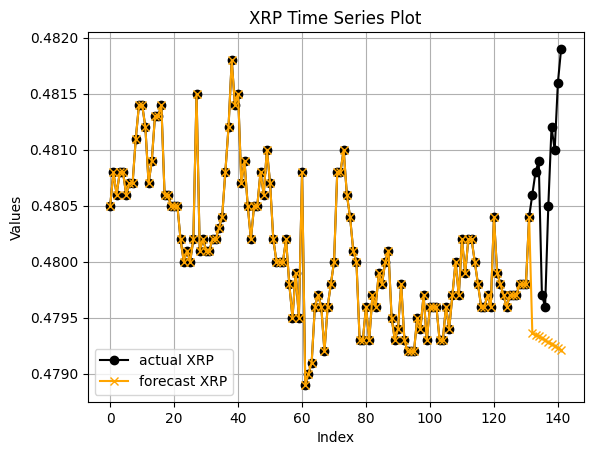

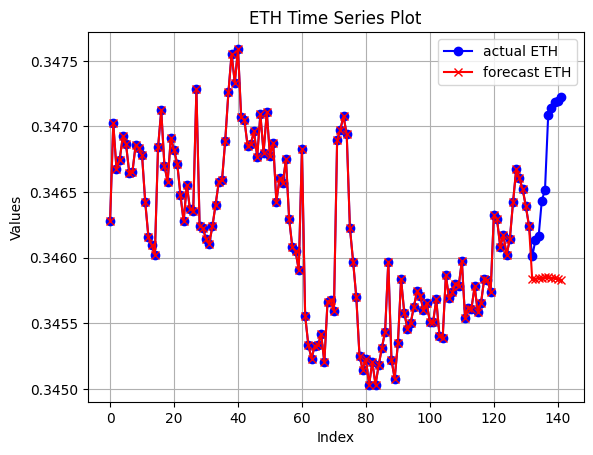

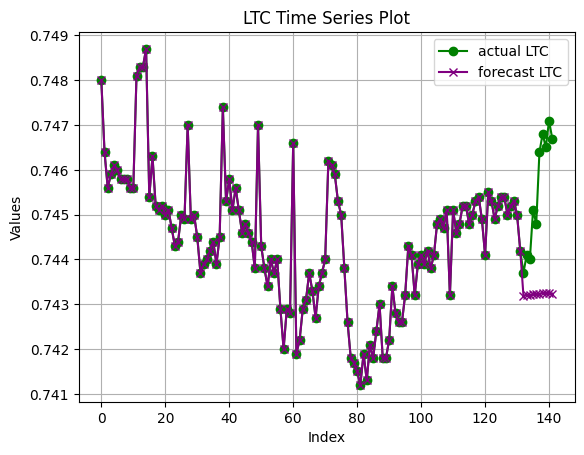

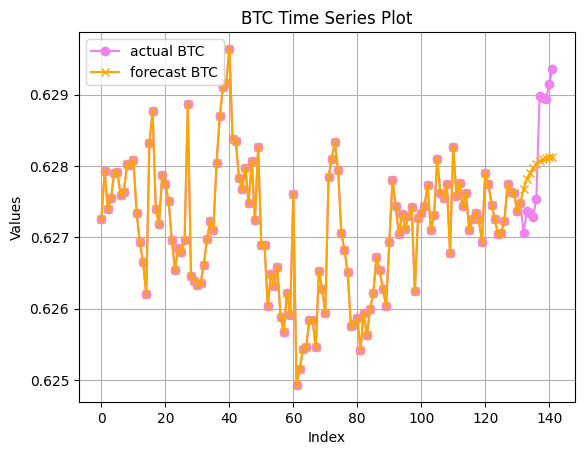

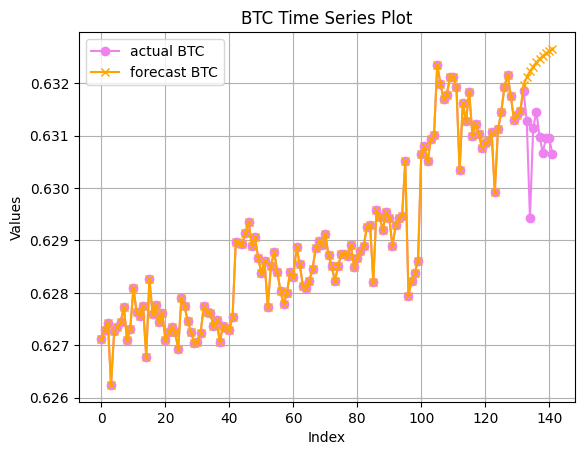

In [126]:
for i in range(batch_valid-cnt_thrown_idx):
    actual = pd.concat([pd.DataFrame(X_valid[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                        pd.DataFrame(y_valid[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                        ignore_index = True)
    # print(actual)
    forecast = pd.concat([pd.DataFrame(X_valid[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                          pd.DataFrame(y_hat[i].reshape(frwd, n_features), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                          ignore_index = True)
    # print(forecast)
# =================== XPR ======================== 
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['XRP'], label = 'actual XRP', marker = 'o', color = 'black')
    ax.plot(forecast.index, forecast['XRP'], label = 'forecast XRP', marker = 'x', color = 'orange')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('XRP Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== ETH ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['ETH'], label = 'actual ETH', marker = 'o', color = 'blue')
    ax.plot(forecast.index, forecast['ETH'], label = 'forecast ETH', marker = 'x', color = 'red')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('ETH Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== LTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['LTC'], label = 'actual LTC', marker = 'o', color = 'green')
    ax.plot(forecast.index, forecast['LTC'], label = 'forecast LTC', marker = 'x', color = 'purple')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('LTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()
# =================== BTC ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['BTC'], label = 'actual BTC', marker = 'o', color = 'violet')
    ax.plot(forecast.index, forecast['BTC'], label = 'forecast BTC', marker = 'x', color = 'orange')
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('BTC Time Series Plot')
    ax.legend() # Add legend
    ax.grid(True) # Add grid
    plt.show()